# Introduction
In this notebook I explore how to create an ensemble classifier and how to hypertune the underlying models. The ensemble uses a variety of tree-based models (random forest, extra random trees, XGBoost, HistBoost, CatBoost, LightGBM) as well as a neural network. The model also uses a hill-climbing approach for determining the weights of the ensemble.

Whilst I have carried out some exploratory data analysis this is not the main focus of this notebook and should be explored further at a later date. 

The overall aim of the model is to try to predict whether a piece of software will have any defects based on certain characteristics.

# Import libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
from random import uniform

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline, TransformerMixin, make_pipeline
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier 
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier, IsolationForest
from sklearn.svm import SVC, LinearSVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

# Import data

In [2]:
train = pd.read_csv('../input/playground-series-s3e23/train.csv')
test = pd.read_csv('../input/playground-series-s3e23/test.csv')
submission = pd.read_csv('../input/playground-series-s3e23/sample_submission.csv')

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

seed = 42

The dimension of the train dataset is: (101763, 23)
The dimension of the test dataset is: (67842, 22)


# Exploratory Data Analysis
First we check to see what features we are working with and if we need to deal with any missing values.

In [3]:
def df_info(df):
    info_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    info_df["Nan"] = df.isna().sum()
    info_df["Nan %"] = df.isna().sum() / len(df)
    info_df["Nunique"] = df.nunique()
    info_df["count"] = df.count()
    print(f"Shape: {df.shape}")
    return info_df.style.background_gradient(cmap='Reds')

df_info(train)

Shape: (101763, 23)


,dtypes,Nan,Nan %,Nunique,count
id,int64,0,0.000000,101763,101763
loc,float64,0,0.000000,378,101763
v(g),float64,0,0.000000,106,101763
ev(g),float64,0,0.000000,71,101763
iv(g),float64,0,0.000000,84,101763
n,float64,0,0.000000,836,101763
v,float64,0,0.000000,4515,101763
l,float64,0,0.000000,55,101763
d,float64,0,0.000000,3360,101763
i,float64,0,0.000000,5171,101763


**We have no missing values in our data set, so we don't need to worry about imputing missing values.**  We do however have a relatively large number of features, which are described below:


1. loc             : numeric % McCabe's line count of code
2. v(g)            : numeric % McCabe "cyclomatic complexity"
3. ev(g)           : numeric % McCabe "essential complexity"
4. iv(g)           : numeric % McCabe "design complexity"
5. n               : numeric % Halstead total operators + operands
6. v               : numeric % Halstead "volume"
7. l               : numeric % Halstead "program length"
8. d               : numeric % Halstead "difficulty"
9. i               : numeric % Halstead "intelligence"
10. e               : numeric % Halstead "effort"
11. b               : numeric % Halstead 
12. t               : numeric % Halstead's time estimator
13. lOCode          : numeric % Halstead's line count
14. lOComment       : numeric % Halstead's count of lines of comments
15. lOBlank         : numeric % Halstead's count of blank lines
16. lOCodeAndComment: numeric
17. uniq_Op         : numeric % unique operators
18. uniq_Opnd       : numeric % unique operands
19. total_Op        : numeric % total operators
20. total_Opnd      : numeric % total operands
21: branchCount     : numeric % of the flow graph
22. defects         : {false,true} % module has/has not one or more  reported defects

All of the features are numeric, so there is no need for categorical preprocessing.

In [4]:
train.head(20)

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False
5,5,23.0,4.0,4.0,3.0,69.0,338.21,0.07,14.15,22.81,...,17,1,2,0,16.0,10.0,40.0,19.0,7.0,False
6,6,24.0,4.0,1.0,4.0,60.0,294.41,0.08,12.46,24.62,...,19,0,3,0,14.0,13.0,40.0,23.0,7.0,False
7,7,14.0,1.0,1.0,1.0,49.0,221.65,0.18,5.47,46.06,...,11,0,2,0,7.0,18.0,26.0,23.0,1.0,False
8,8,34.0,10.0,1.0,4.0,122.0,684.98,0.07,14.33,43.43,...,29,1,3,0,16.0,29.0,75.0,47.0,19.0,False
9,9,9.0,2.0,1.0,2.0,16.0,55.35,0.11,9.00,6.15,...,4,0,2,0,9.0,2.0,12.0,4.0,3.0,False


<Axes: xlabel='defects'>

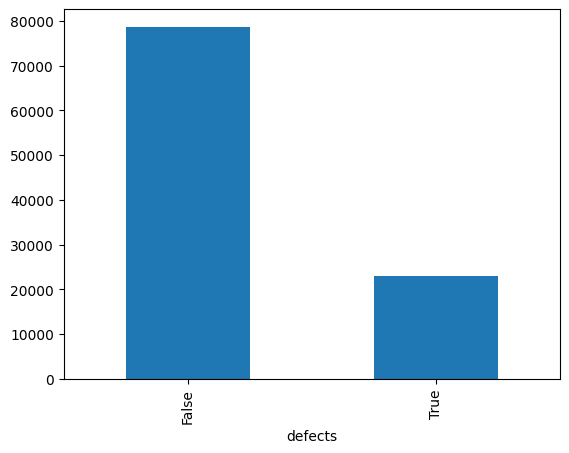

In [5]:
plot_df = train["defects"].value_counts()
plot_df.plot(kind="bar")

The labels are imbalanced, with significantly more False values than True values.  **As such we need to remember to use stratified sampling when carrying out our cross validation later.**

Next we consider the distributions of each of the features in the dataset.

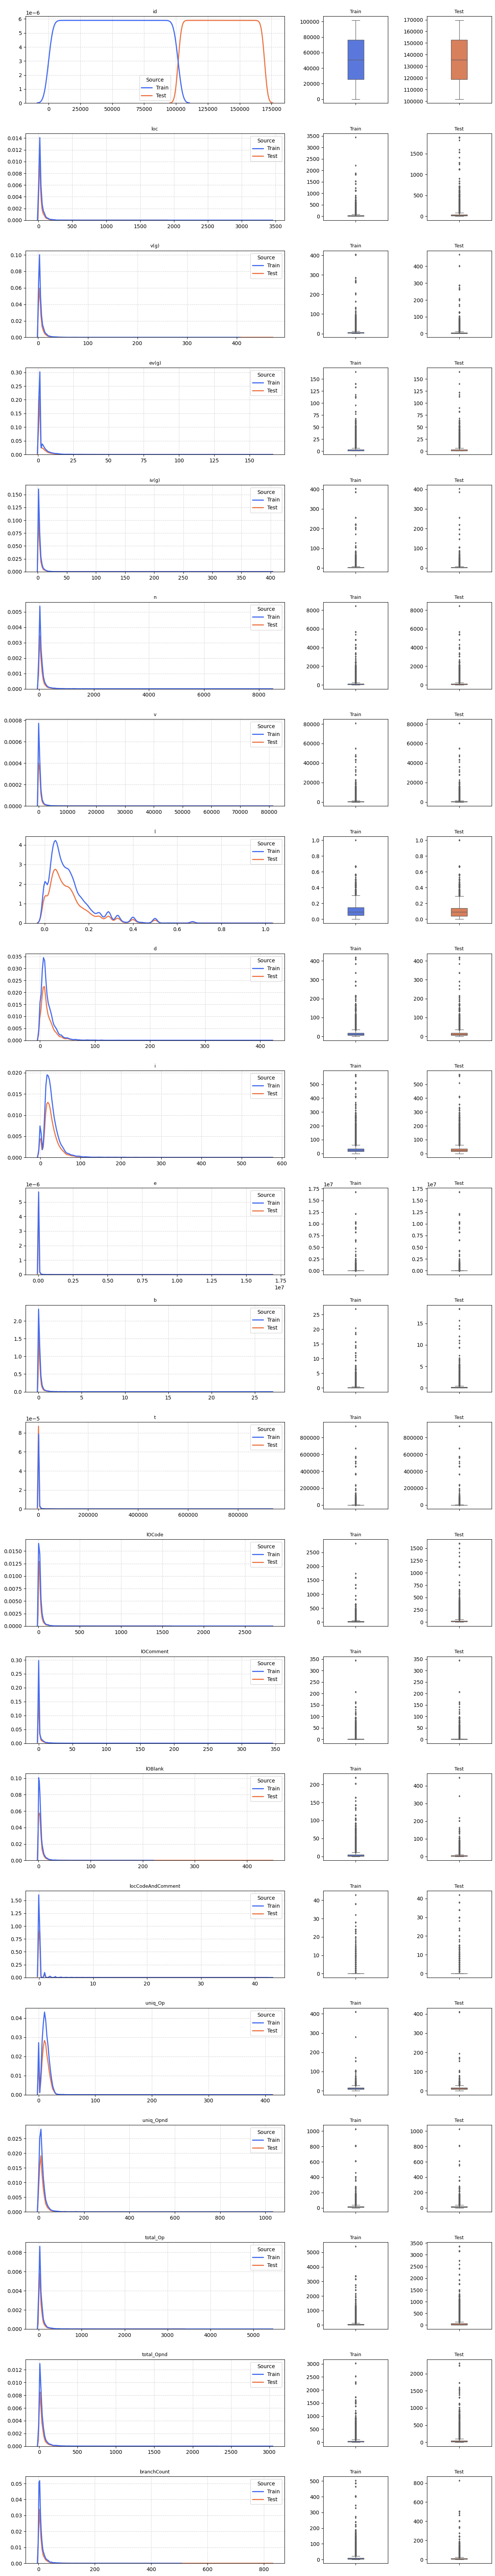

In [6]:
#Get the distribution of each numerical feature/column in the dataset
num = train.select_dtypes(include=['int','float']).columns

df = pd.concat([train[num].assign(Source = 'Train'), test[num].assign(Source = 'Test')], ignore_index = True)

# Use of more advanced artistic matplotlib interface (see the axes)
fig, axes = plt.subplots(len(num), 3 ,figsize = (16, len(num) * 4), gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20]})

for i,col in enumerate(num):
    ax = axes[i,0]
    sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', palette=['#456cf0', '#ed7647'], linewidth = 2.1, warn_singular=False, ax = ax) # Use of seaborn with artistic interface
    ax.set_title(f"\n{col}",fontsize = 9)
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75)
    ax.set(xlabel = '', ylabel = '')

    ax = axes[i,1]
    sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#456cf0', ax = ax)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title("Train", fontsize = 9)

    ax = axes[i,2]
    sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#ed7647', ax = ax)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title("Test", fontsize = 9)

plt.show()

The main conclusions from this analysis are that:
* the training and test set distributions are similar ie **there is no data drift.**
*  most of the features are right-skewed distribution, which suggests **we should apply a log transform**.



Next we can look further at the distribution of the data for each feature split by label both as a stacked bar chart and as a box plot.  I also calculate the correlations between the different features and create scatter plots for each pair of features.  Typically this would help inform whether we need to carry out further feature engineering or selection. However, as noted previously this will not be a focus for this notebook.  As such these charts are for interest only.

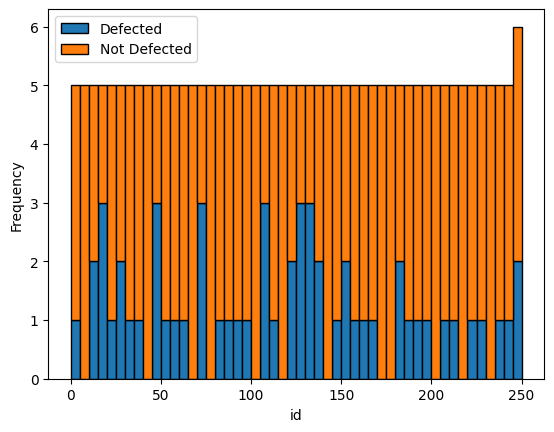

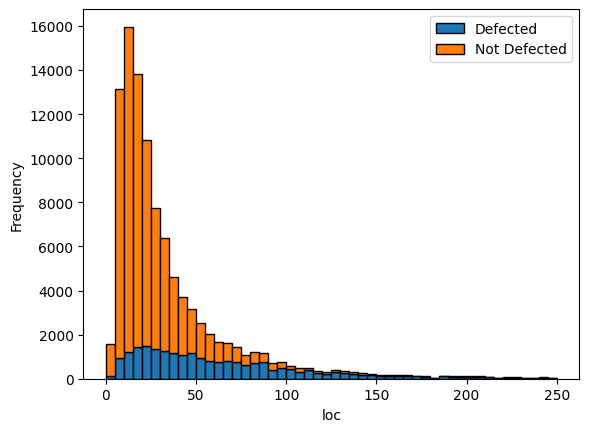

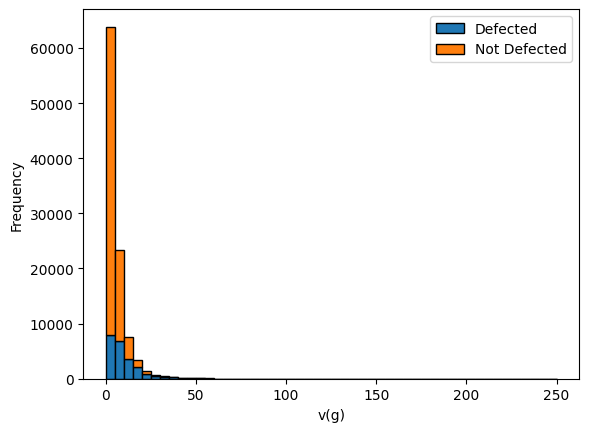

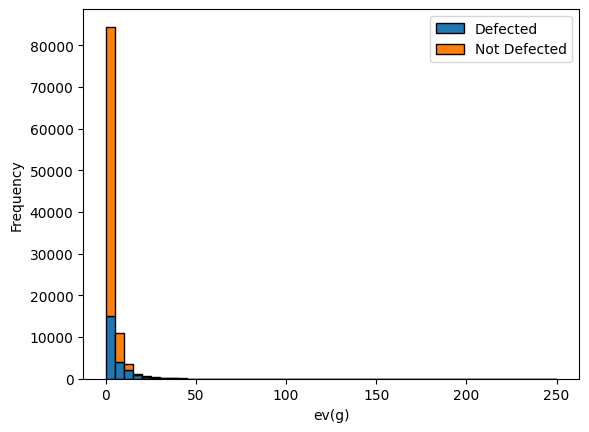

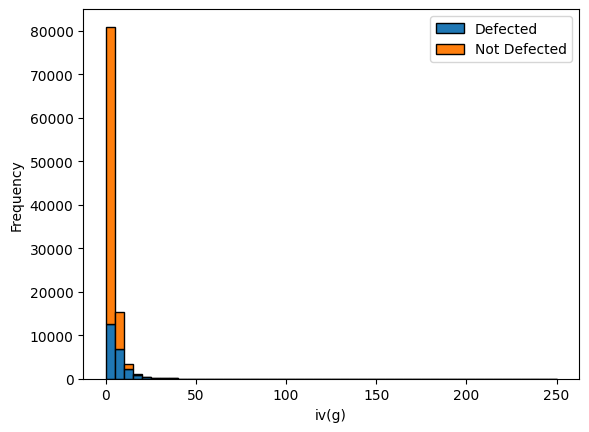

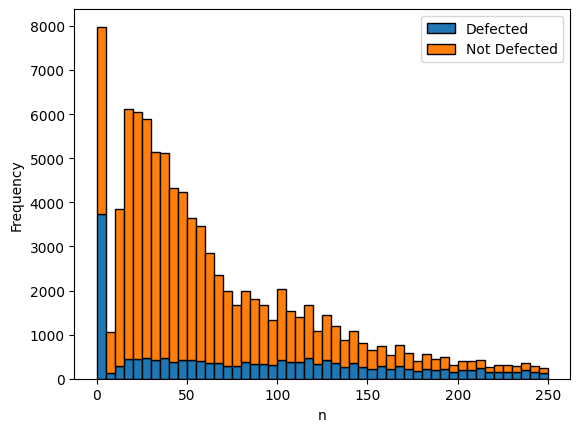

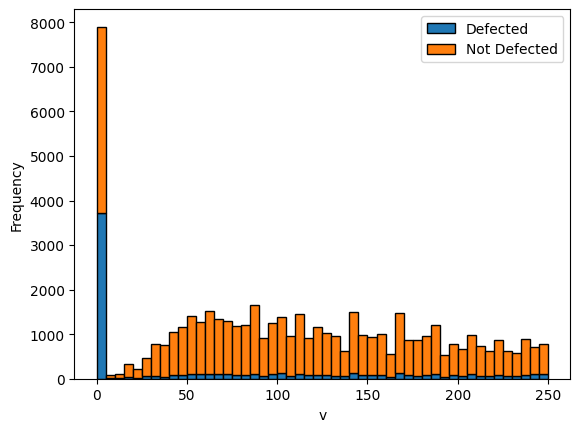

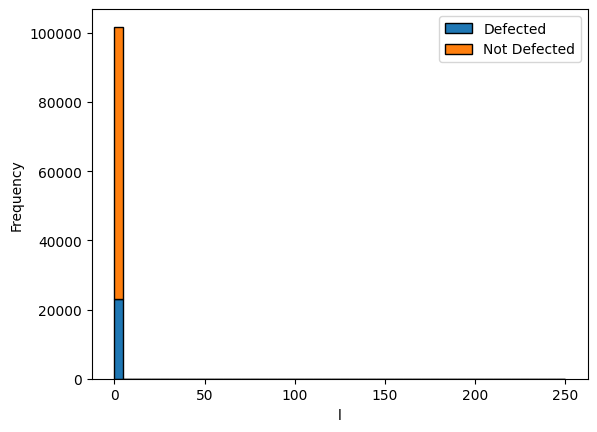

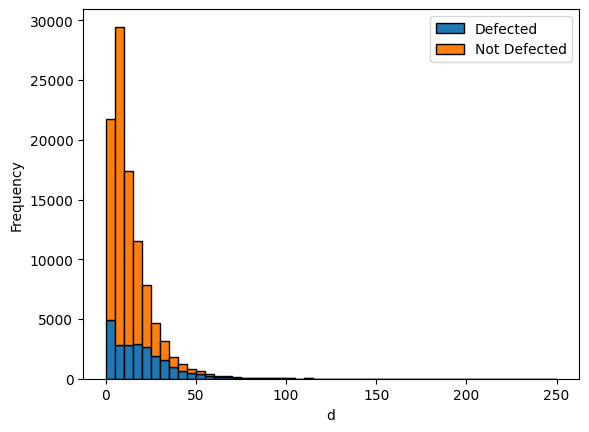

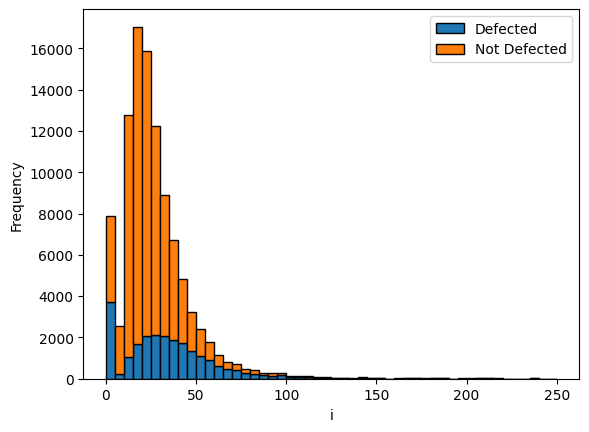

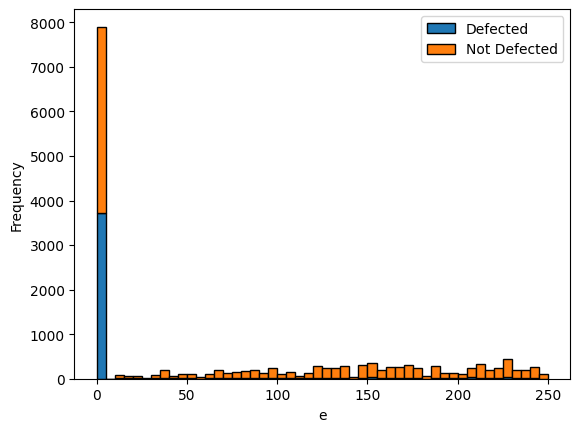

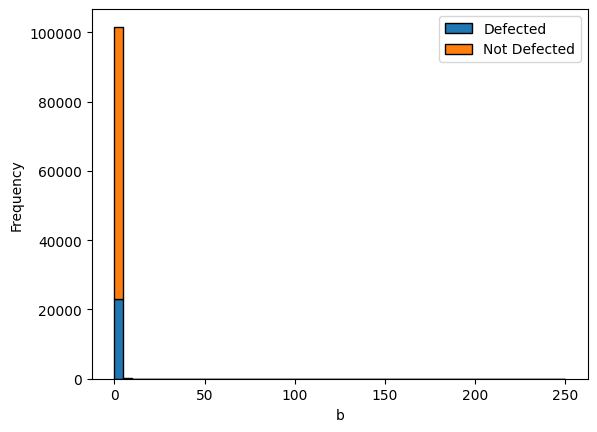

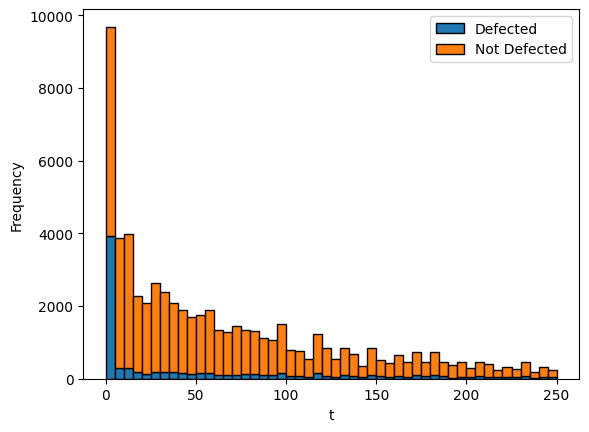

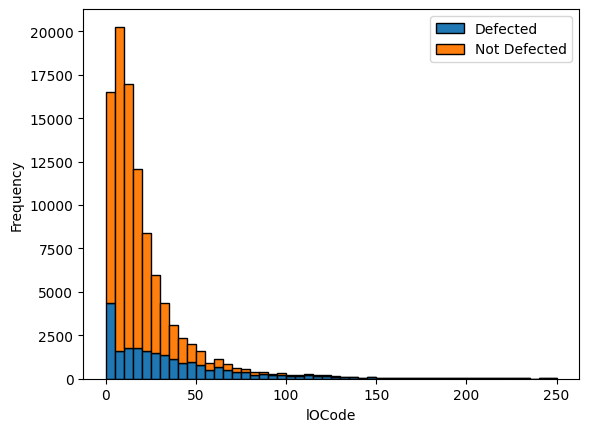

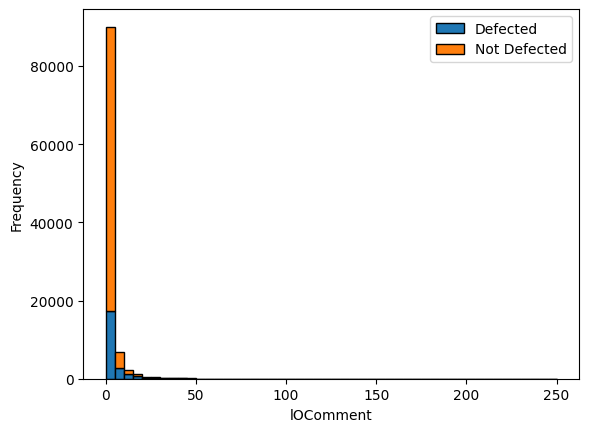

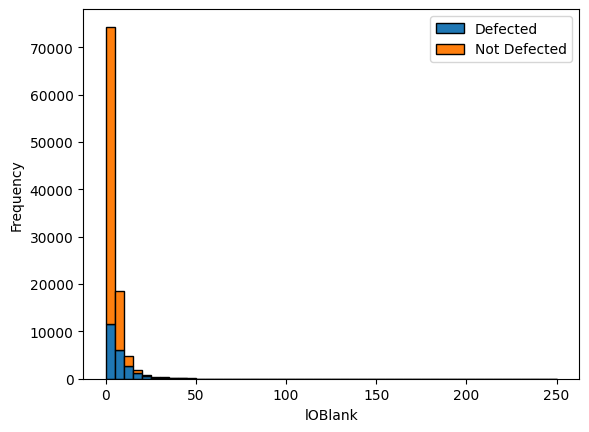

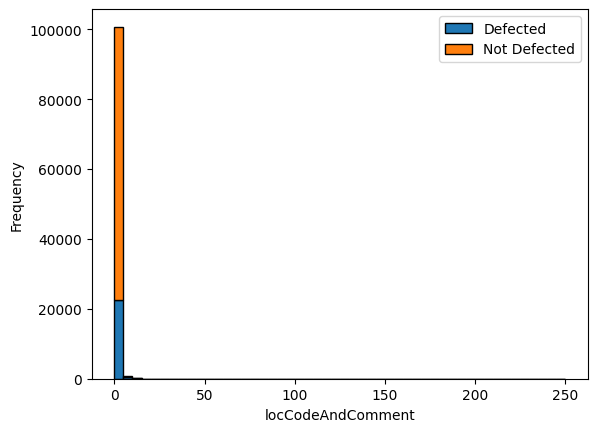

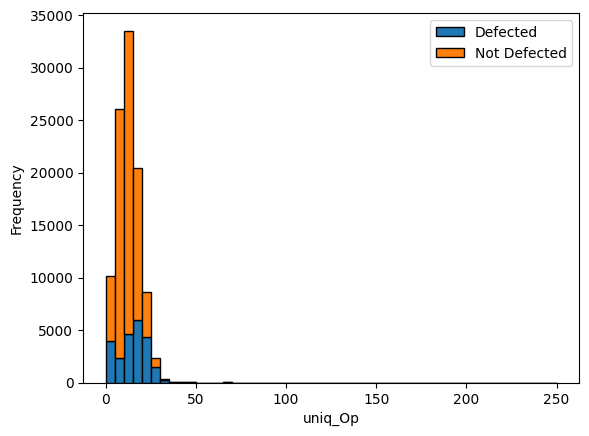

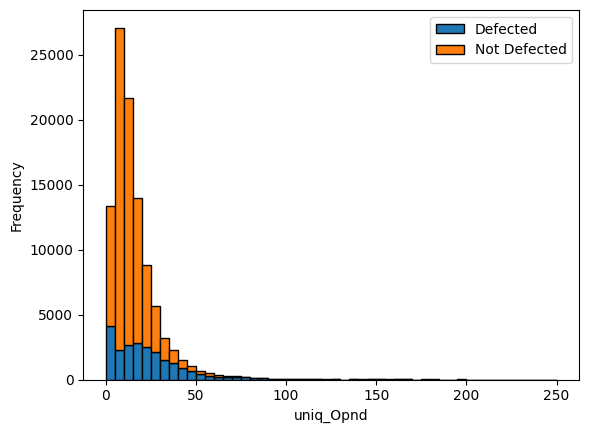

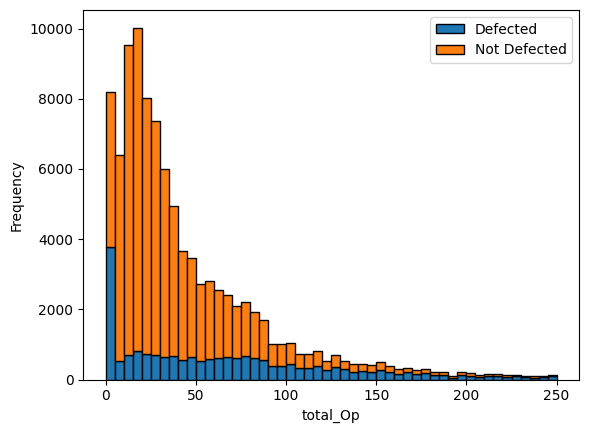

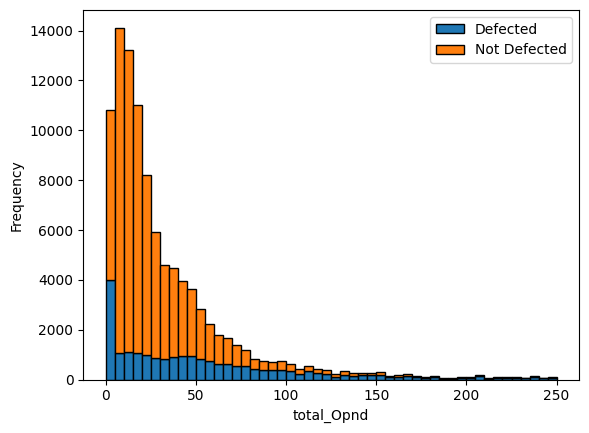

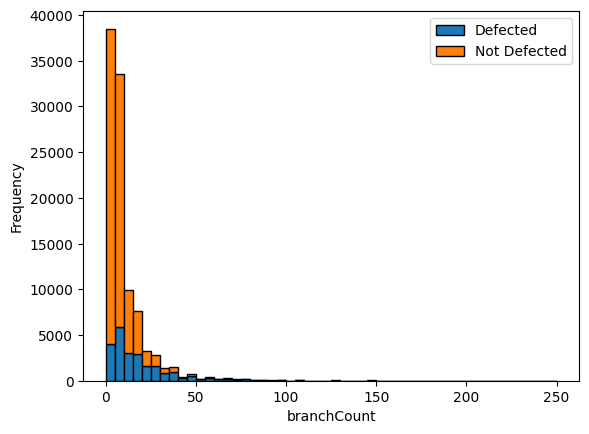

In [7]:
def  create_stacked_histogram(column, target, train_data, range = (0, 500)):

    # Create subsets for each label
    label_1_data = train_data[train_data[target] == True][column]
    label_0_data = train_data[train_data[target] == False][column]

    # Create stacked histogram for age
    plt.figsize = (8,8)
    plt.hist([label_1_data, label_0_data],
             bins=50, 
             label=['Defected', 'Not Defected'], 
             stacked=True, 
             edgecolor='black',
             range = range
            )
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

for col in train.drop('defects', axis=1).columns:
    create_stacked_histogram(col, 'defects', train, (0, 250))

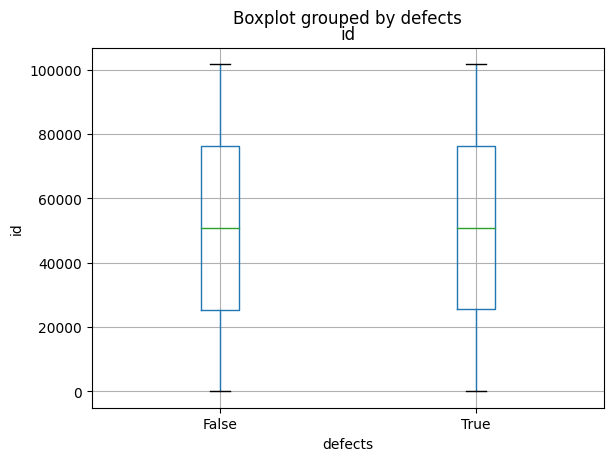

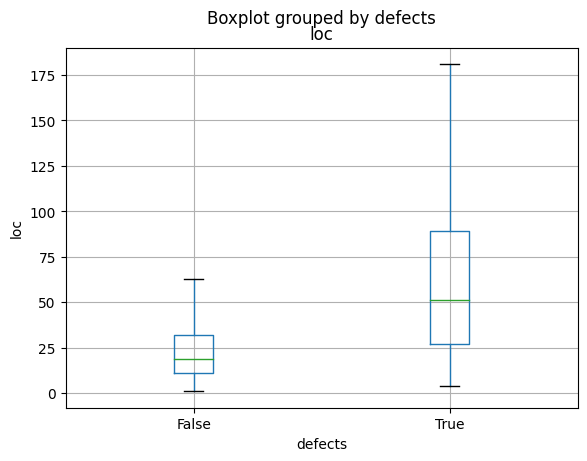

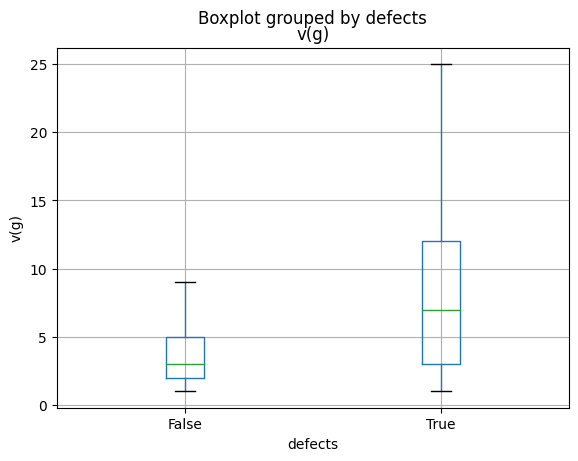

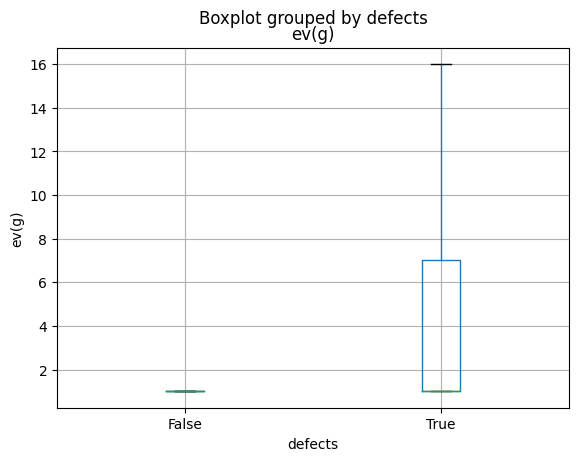

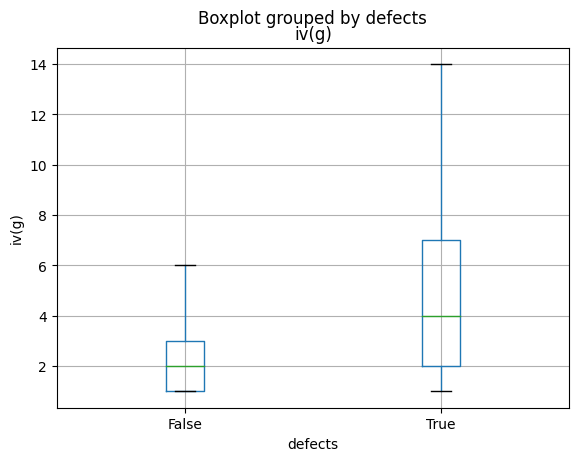

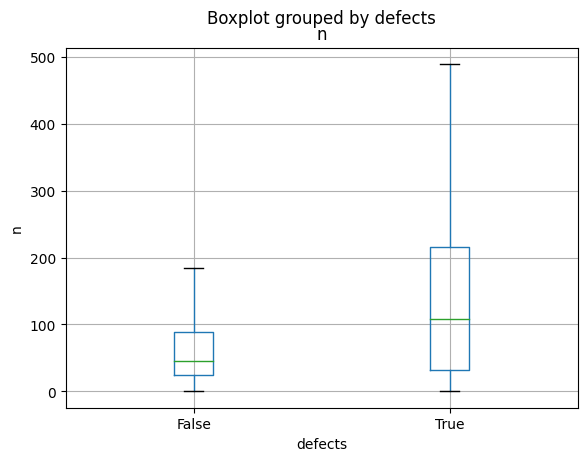

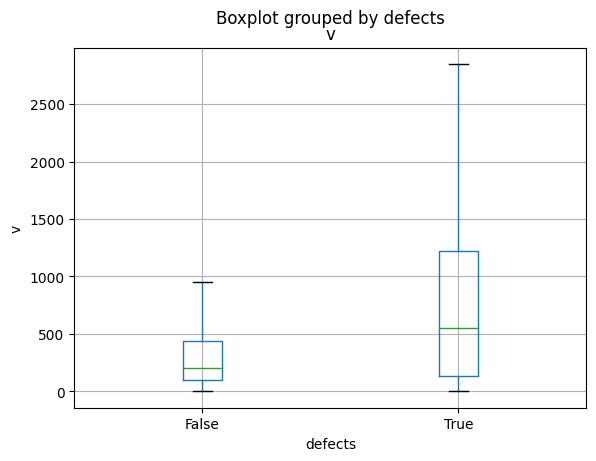

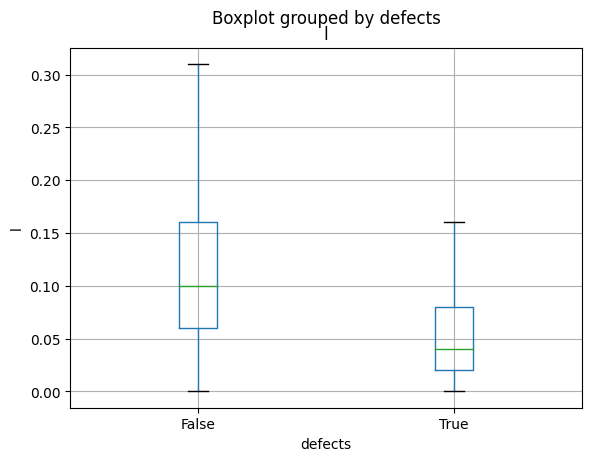

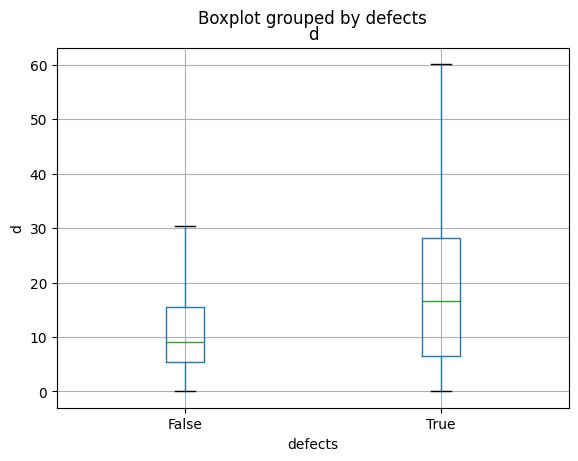

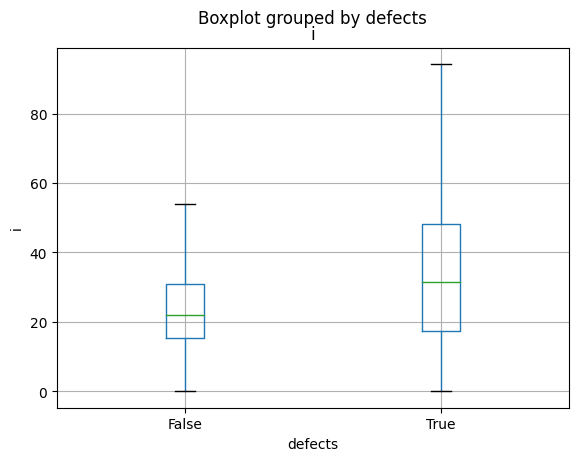

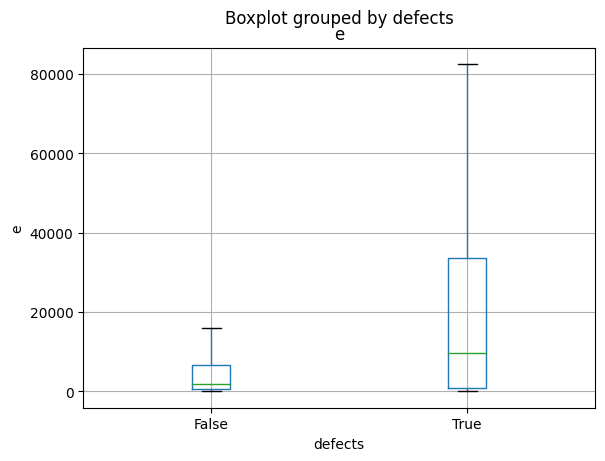

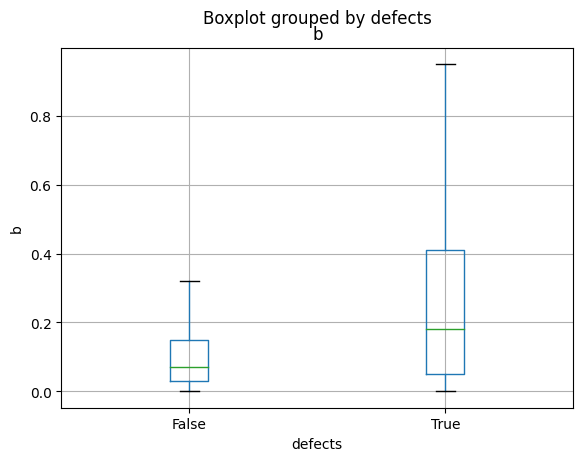

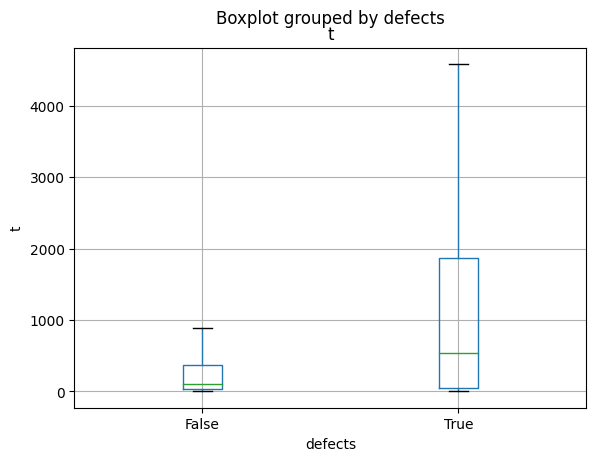

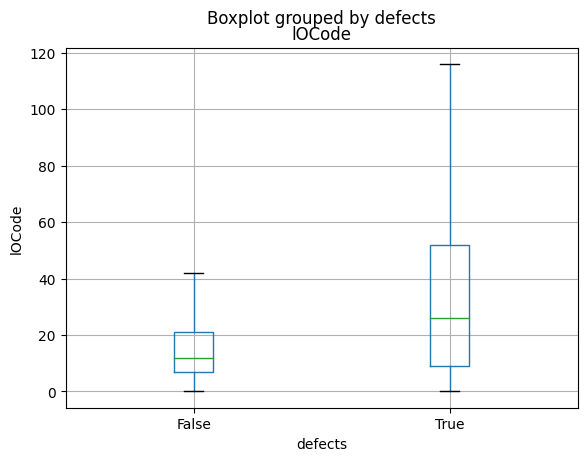

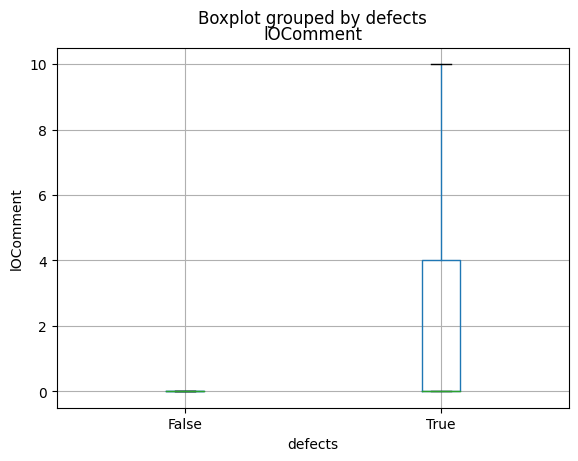

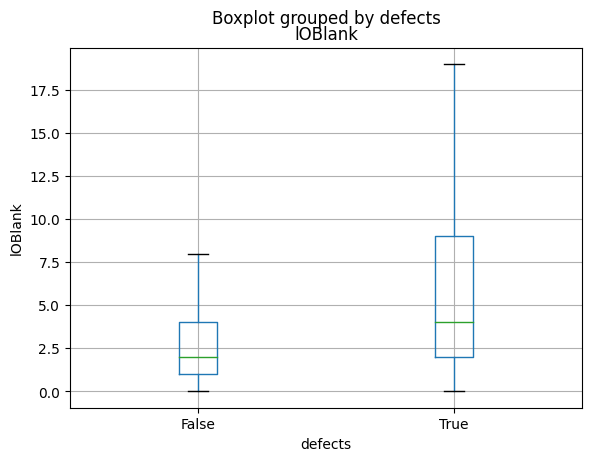

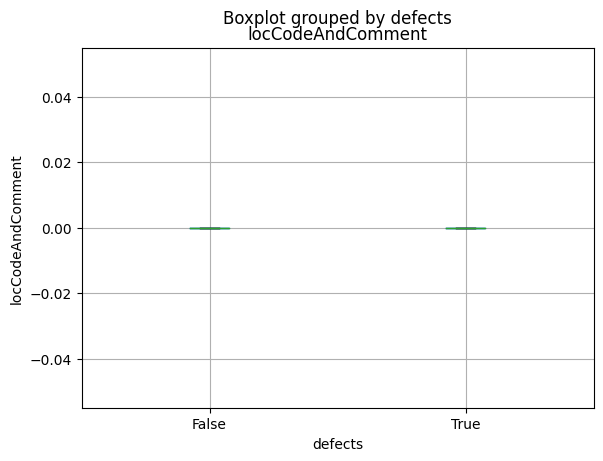

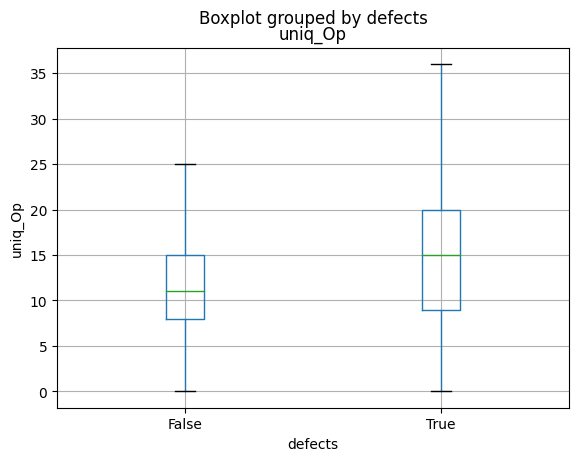

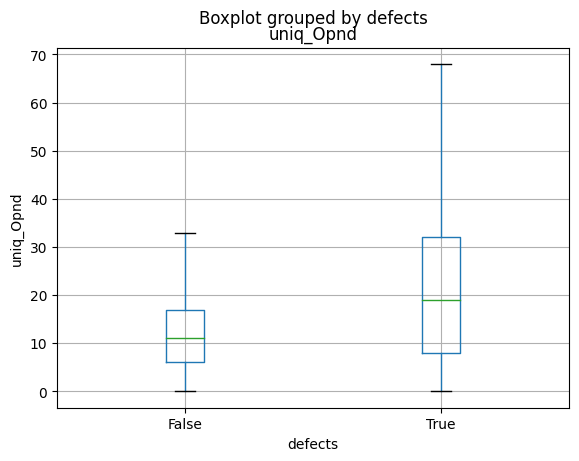

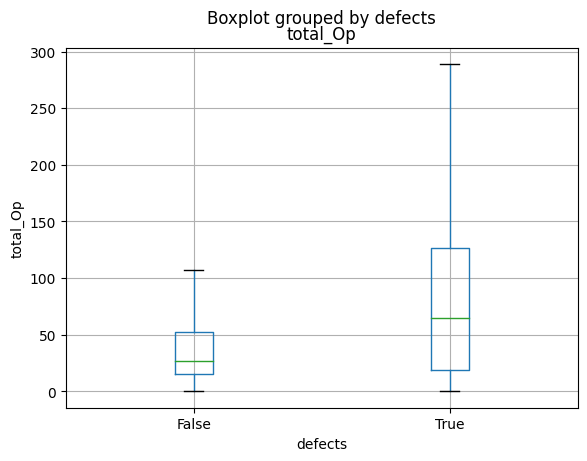

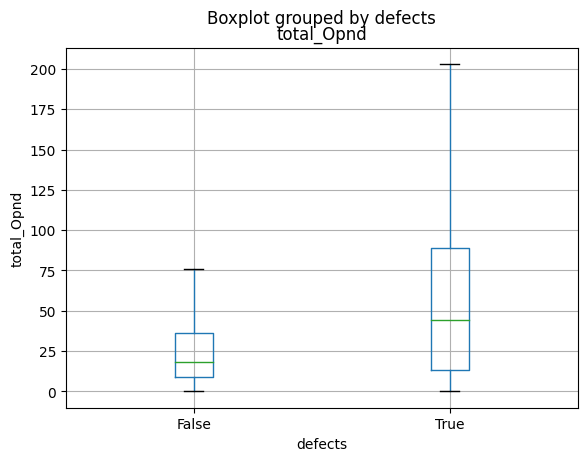

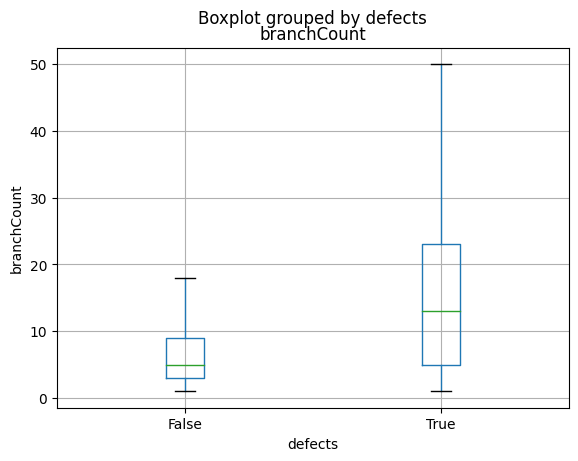

In [8]:
def create_boxplot(variable, target, train_data):
    # Create separate boxplots for each category in the 'target' column
    train_data.boxplot(column=variable, by=target, showfliers=False)

    # Set plot labels and title
    plt.xlabel('defects')
    plt.ylabel(variable)
    #plt.title('Boxplot by Target Category')

    # Show the plot
    plt.show()

for col in train.drop('defects', axis=1).columns:
     create_boxplot(col, 'defects', train)

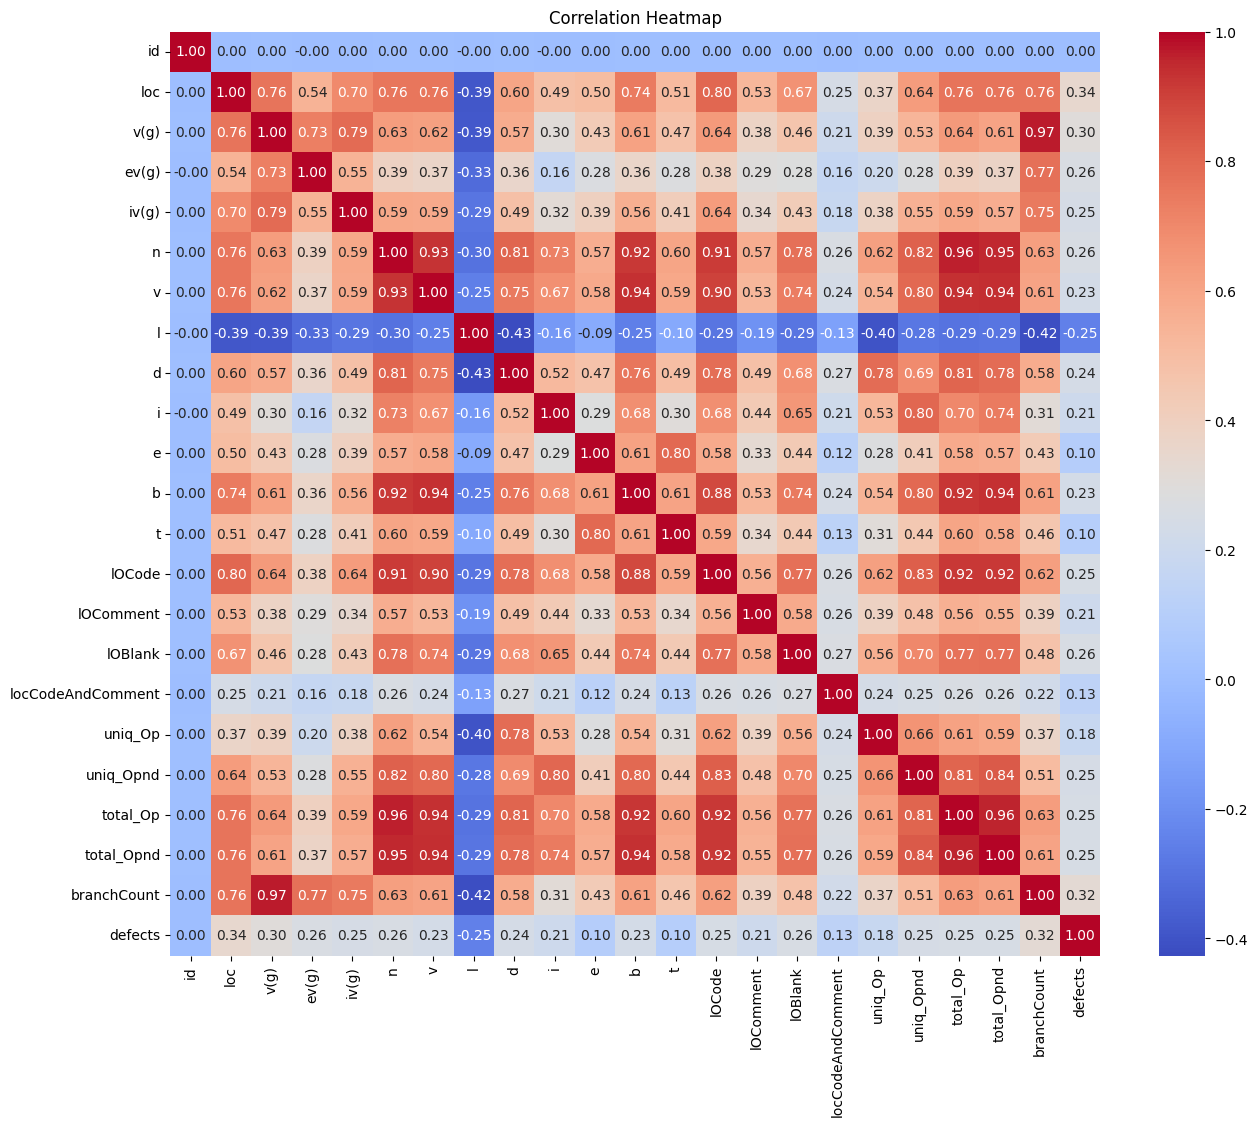

In [9]:
corr = train.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

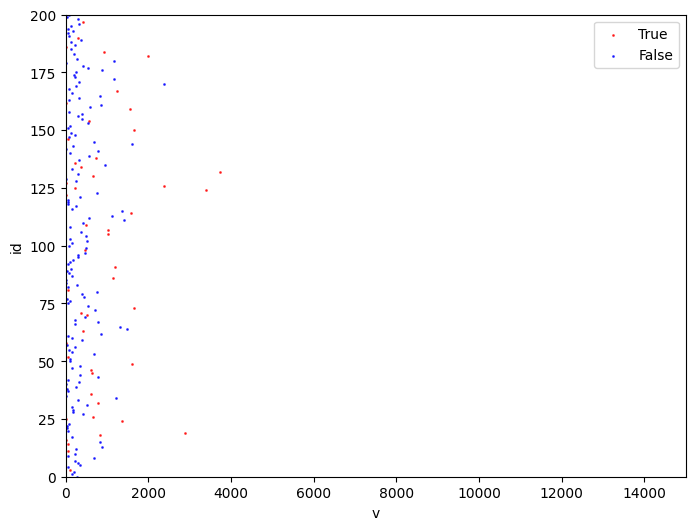

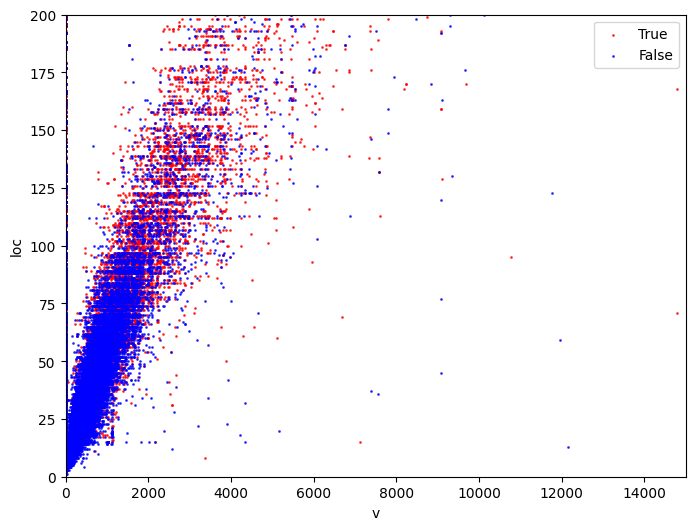

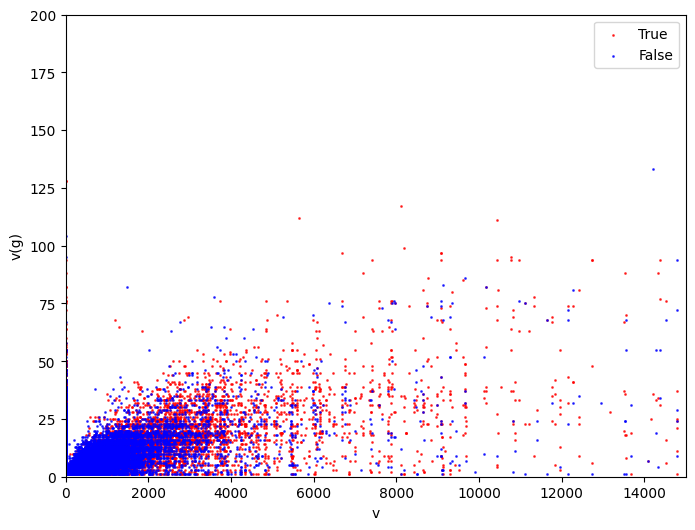

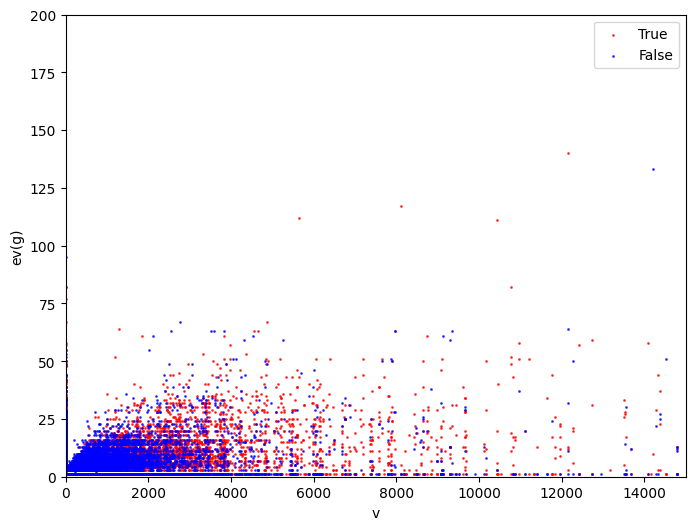

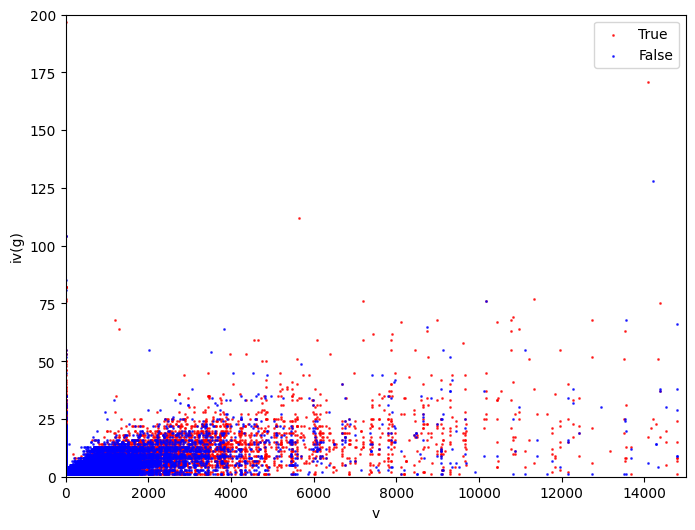

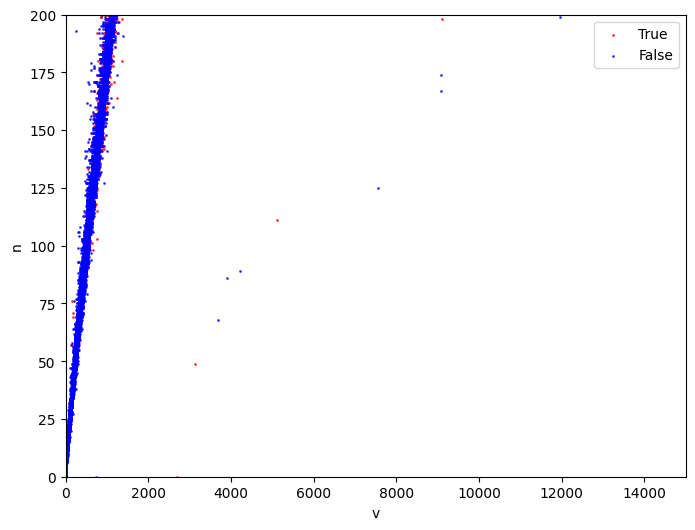

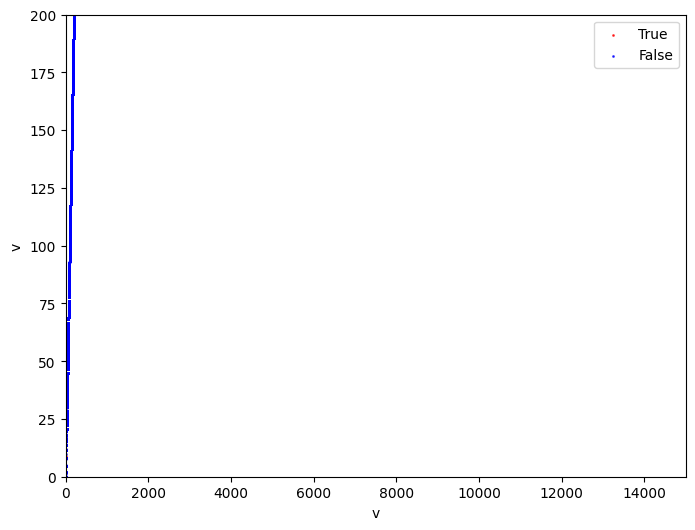

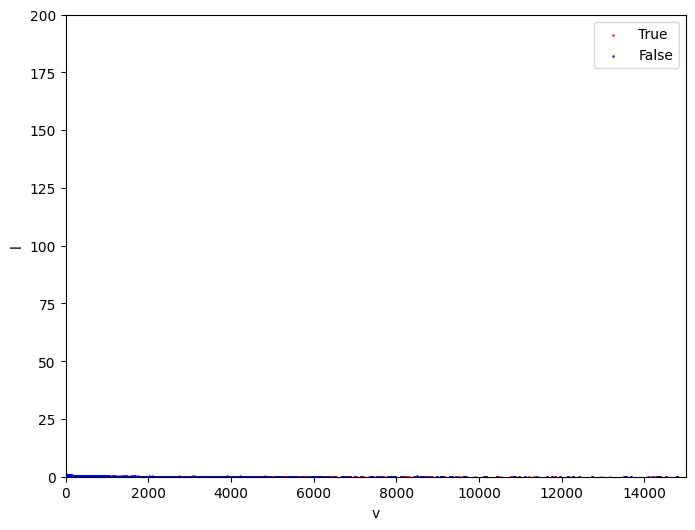

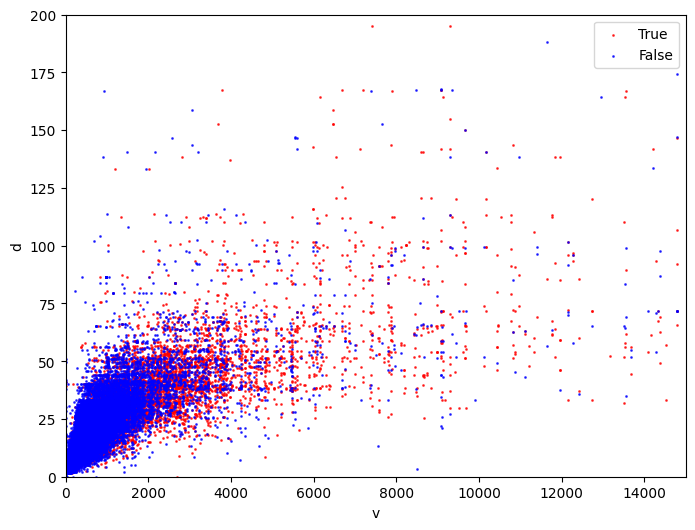

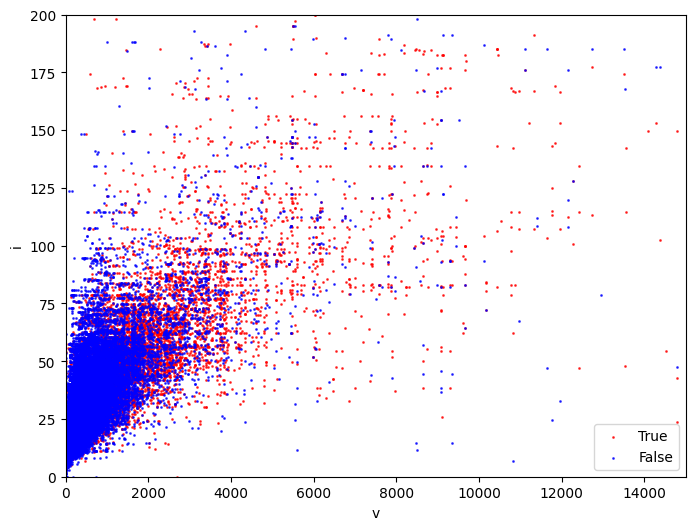

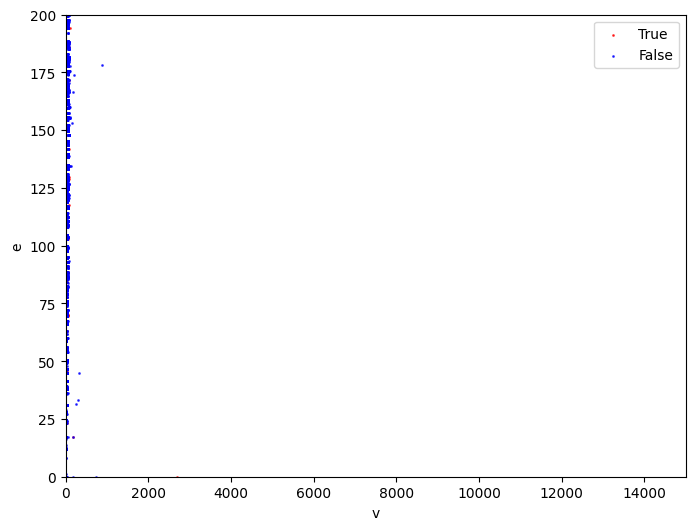

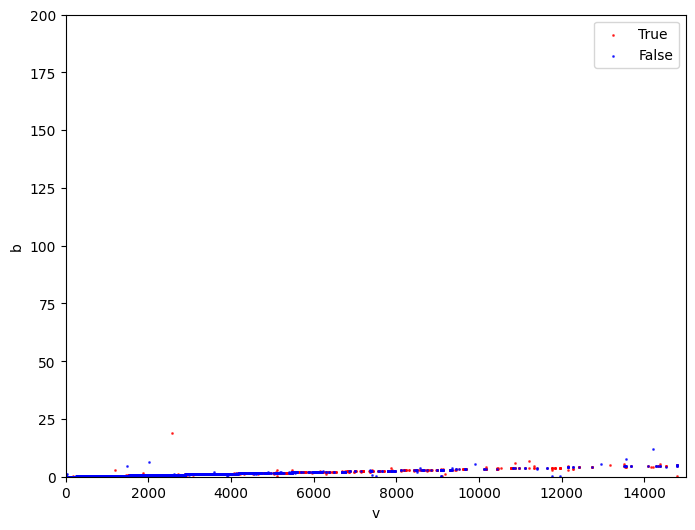

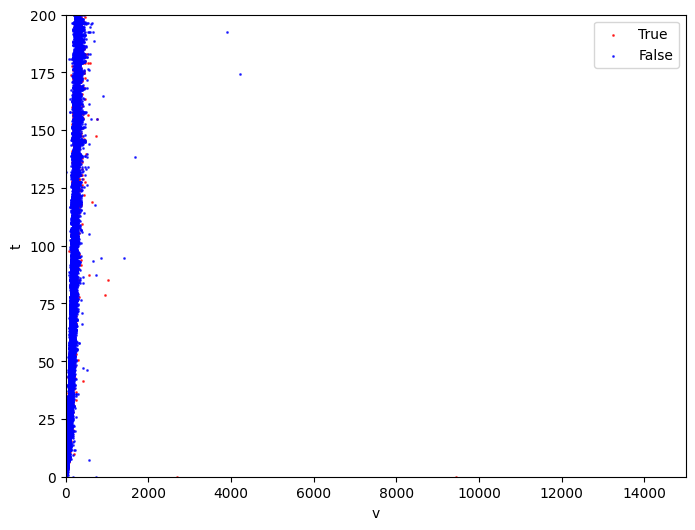

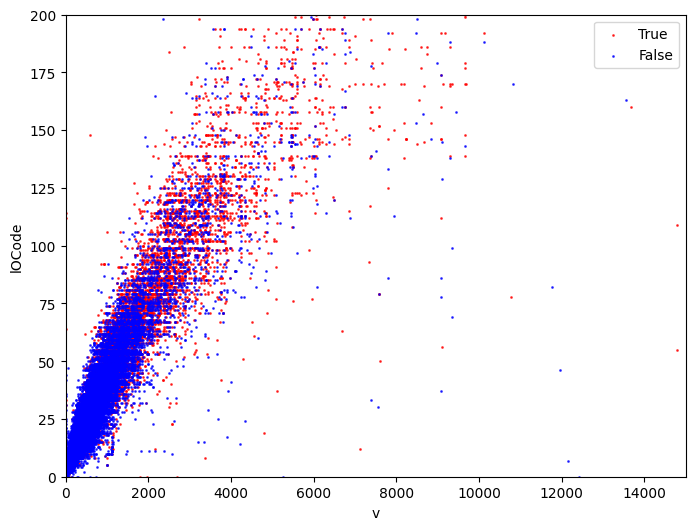

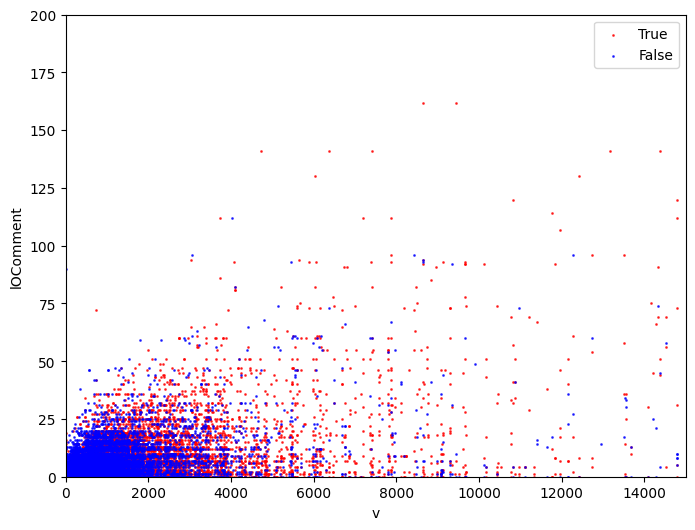

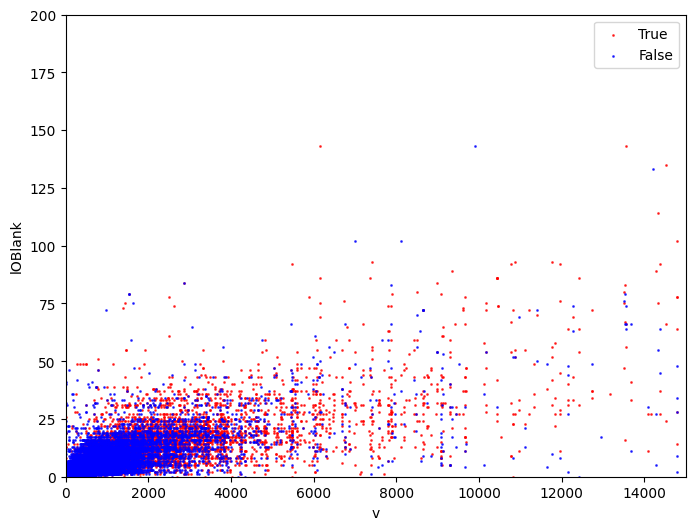

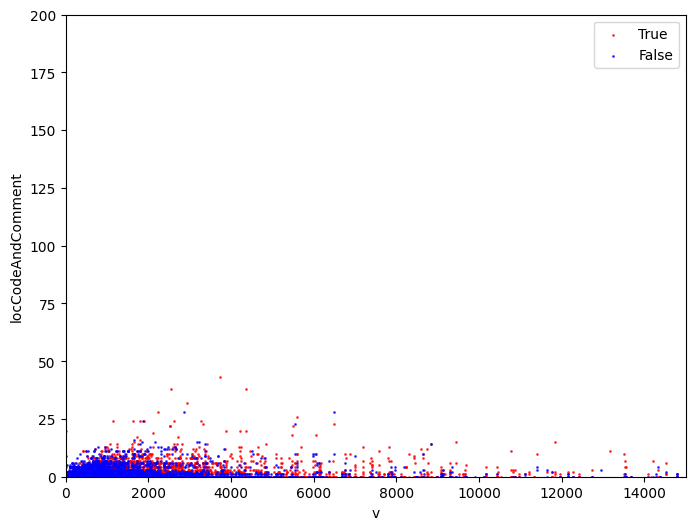

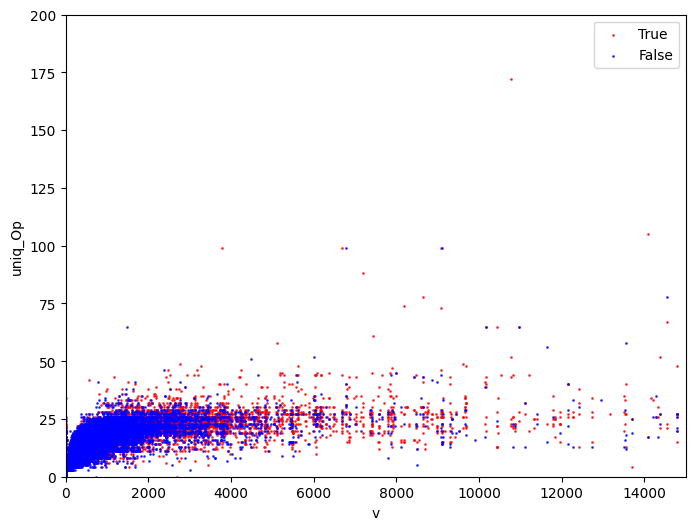

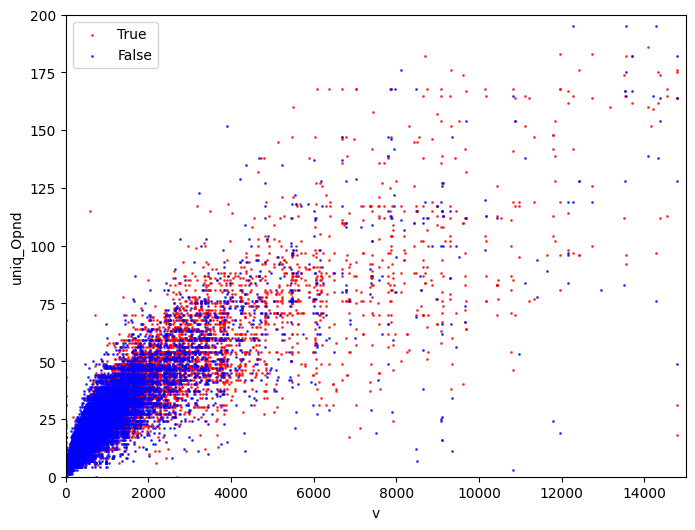

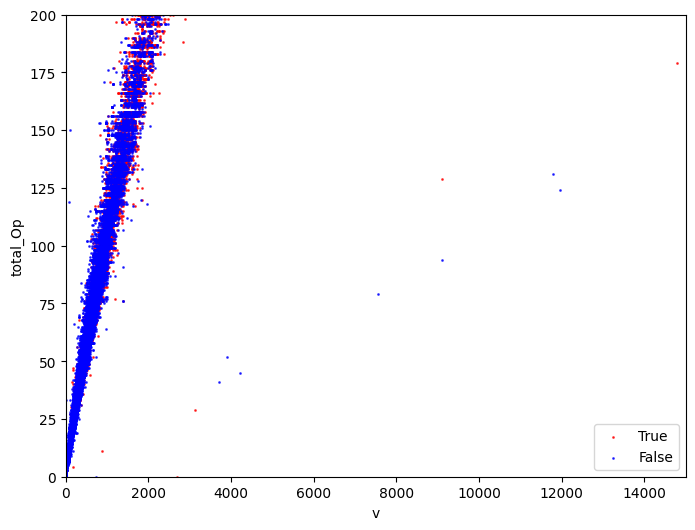

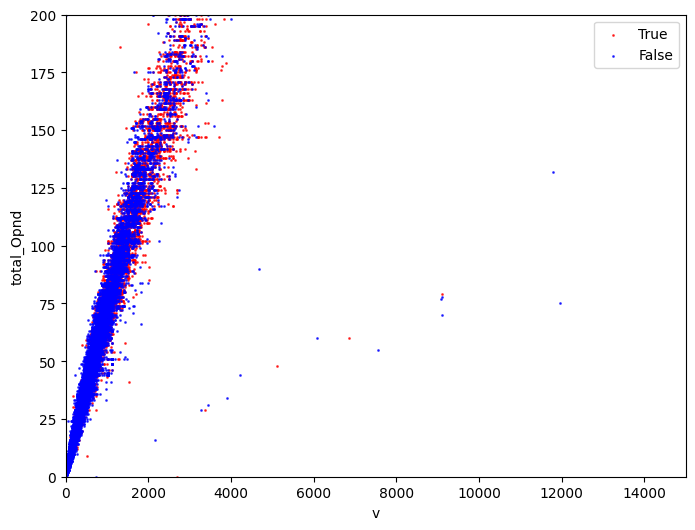

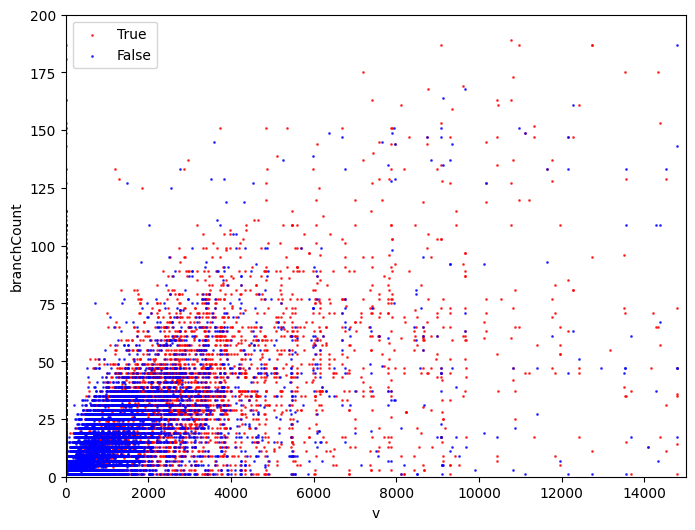

In [10]:
def create_scatter(variable1, variable2, target, train_data):
    # Define colors for each label
    colors = {True: 'red', False: 'blue'}

    # Create a scatterplot and color code points based on labels
    plt.figure(figsize=(8, 6))
    for label, color in colors.items():
        subset = train[train[target] == label]
        plt.scatter(subset[variable1], subset[variable2], label=label, color=color, alpha=0.7, s =1)

    # Set labels and legend
    plt.xlabel(variable1)
    plt.ylabel(variable2)
    plt.legend()
    
    plt.xlim(0, 15000)  
    plt.ylim(0, 200)
    
    # Show the plot
    plt.show()

for col in train.drop('defects', axis=1).columns:
    create_scatter('v',col, 'defects', train)

# Data preprocessing
From our exploratory data analysis we only need to carry out minimal data preprocessing.  The steps carried out below are to:
* Drop the id column from the training and test data
* Seperate the training data from the labels
* Apply the log transfrom to the training and test data

In [11]:
X = train.drop(columns = ['id', 'defects'], axis = 1)
X = X.apply(lambda x: np.log1p(x))

Y = train['defects'].map({False: 0, True: 1})

test_cv = test.drop(columns = ['id'], axis = 1)
test_cv = test_cv.apply(lambda x: np.log1p(x))

Before creating our model we can also view how important each of the variables is in determing the prediction (when using a random forest model).

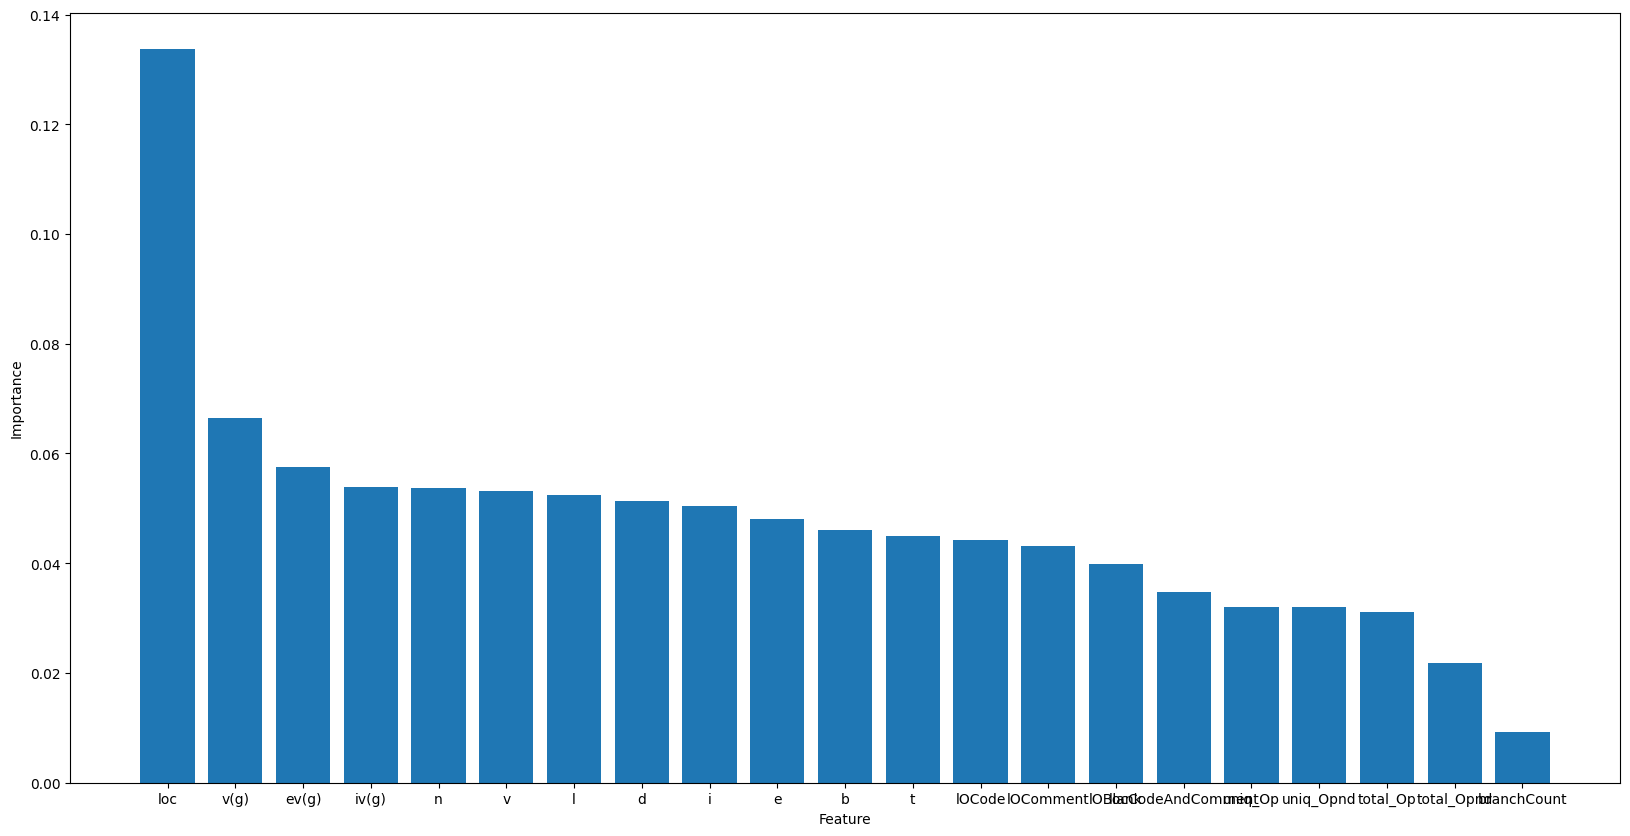

In [12]:
#Look at the degree of importance of every column/feature in the dataset
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X.copy(), Y.copy())

feature_importance = rf_classifier.feature_importances_

importance_df = pd.DataFrame({'feature': X.columns,
                              'importance': feature_importance})

importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(20, 10))
plt.bar(range(X.shape[1]), importance_df['importance'])  
plt.xticks(range(X.shape[1]), X.columns)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

# Hypertuning model parameters
The next sections tune the hyperparamters for each of the underlying ensemble methods using a randomised search 5-fold cross-validation. The number of iterations can be increased to run the search for longer.

# Random Forest

In [13]:
# # Set up the RandomForest classifier with default hyperparameters

# model = RandomForestClassifier()

# full_pipeline = Pipeline([
#     ("model", model)
# ])

# # Define the hyperparameters to tune and their search ranges
# param_dist = {
#     'model__n_estimators': [100, 200, 300, 400, 500, 600],
#     'model__max_depth': [5, 10, 20, 30, 40],
#     'model__min_samples_split': [2, 5, 10, 15, 20],
#     'model__min_samples_leaf': [2, 4, 7, 10, 15, 20],
#     'model__criterion': ['gini', 'entropy'],
#     'model__max_samples': [0.5, 0.7, 0.8, 0.9, 1.0],
# }


# # Set up the RandomizedSearchCV object with cross-validation
# random_search = RandomizedSearchCV(full_pipeline, 
#                                    param_distributions=param_dist, 
#                                    cv=5,
#                                    scoring='roc_auc', 
#                                    n_iter=10, 
#                                    random_state=seed, 
#                                    n_jobs=-1,
#                                    verbose =2)

# # Fit the RandomizedSearchCV object to the training data
# random_search.fit(X, Y)

# # Print the best hyperparameters and corresponding mean cross-validation score
# print("Best hyperparameters: ", random_search.best_params_)
# print("Best mean cross-validation score: {:.3f}".format(random_search.best_score_))

# # # Evaluate the best model on the test data
# # best_tuned_model = random_search.best_estimator_

# results = pd.DataFrame(random_search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
# results.sort_values('mean_test_score')

# Extra Trees

In [14]:
# # Set up the Extremely RandomForest classifier with default hyperparameters

# model = ExtraTreesClassifier()

# full_pipeline = Pipeline([
#     ("model", model)
# ])

# # Define the hyperparameters to tune and their search ranges
# param_dist = {
#     'model__n_estimators': [100, 200, 300, 400, 500, 600, 700],
#     'model__max_depth': [10, 15, 20, 25, 30],
#     'model__min_samples_split': [2, 5, 10, 15, 20],
#     'model__min_samples_leaf': [1, 2, 4, 10, 15, 20],
#     'model__bootstrap': [True, False],
#     'model__criterion': ['gini', 'entropy'],
# }


# # Set up the RandomizedSearchCV object with cross-validation
# random_search = RandomizedSearchCV(full_pipeline, 
#                                    param_distributions=param_dist, 
#                                    cv=5,
#                                    scoring='roc_auc', 
#                                    n_iter=10, 
#                                    random_state=seed, 
#                                    n_jobs=-1,
#                                    verbose =2)

# # Fit the RandomizedSearchCV object to the training data
# random_search.fit(X, Y)

# # Print the best hyperparameters and corresponding mean cross-validation score
# print("Best hyperparameters: ", random_search.best_params_)
# print("Best mean cross-validation score: {:.3f}".format(random_search.best_score_))

# # # Evaluate the best model on the test data
# # best_tuned_model = random_search.best_estimator_

# results = pd.DataFrame(random_search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
# results.sort_values('mean_test_score')

# Histogram Gradient Boosting

In [15]:
# Set up the Histogram Gradient Boosting classifier with default hyperparameters

# model = HistGradientBoostingClassifier()

# full_pipeline = Pipeline([
#     ("model", model)
# ])

# # Define the hyperparameters to tune and their search ranges
# param_dist = {
#     'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'model__max_iter': [100, 200, 300, 400, 500],
#     'model__max_leaf_nodes': [15, 31, 63, 127],
#     'model__max_depth': [3, 5, 7, 9, 11],
#     'model__min_samples_leaf': [5, 10, 15, 20],
#     'model__l2_regularization': [0.0, 0.01, 0.1, 1.0],
#     'model__max_bins': [100, 150, 200, 255]
# }


# # Set up the RandomizedSearchCV object with cross-validation
# random_search = RandomizedSearchCV(full_pipeline, 
#                                    param_distributions=param_dist, 
#                                    cv=5,
#                                    scoring='roc_auc', 
#                                    n_iter=20, 
#                                    random_state=seed, 
#                                    n_jobs=-1,
#                                    verbose =2)

# # Fit the RandomizedSearchCV object to the training data
# random_search.fit(X, Y)

# # Print the best hyperparameters and corresponding mean cross-validation score
# print("Best hyperparameters: ", random_search.best_params_)
# print("Best mean cross-validation score: {:.3f}".format(random_search.best_score_))

# # # Evaluate the best model on the test data
# # best_tuned_model = random_search.best_estimator_

# results = pd.DataFrame(random_search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
# results.sort_values('mean_test_score')

# LGBM

In [16]:
# # Set up the LightGBM classifier with default hyperparameters

# model = LGBMClassifier()

# full_pipeline = Pipeline([
#     ("model", model)
# ])

# # Define the hyperparameters to tune and their search ranges
# param_dist = {
#     'model__n_estimators': [100, 200, 300, 400, 500],
#     'model__max_depth': [3, 5, 7, 9, 11, 13, 15],
#     'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'model__subsample': [0.1,0.3,0.5,0.7,0.9],
#     'model__colsample_bytree': [0.1,0.3,0.5,0.7,0.9],
#     'model__reg_alpha': sp.stats.uniform(0, 1),
#     'model__reg_lambda': sp.stats.uniform(0, 1),
#     'model__num_leaves': [25, 50, 75, 100, 150],
# }


# # Set up the RandomizedSearchCV object with cross-validation
# random_search = RandomizedSearchCV(full_pipeline, 
#                                    param_distributions=param_dist, 
#                                    cv=5,
#                                    scoring='roc_auc', 
#                                    n_iter=2, 
#                                    random_state=seed, 
#                                    n_jobs=-1,
#                                    verbose =2)

# # Fit the RandomizedSearchCV object to the training data
# random_search.fit(X, Y)

# # Print the best hyperparameters and corresponding mean cross-validation score
# print("Best hyperparameters: ", random_search.best_params_)
# print("Best mean cross-validation score: {:.3f}".format(random_search.best_score_))

# # # Evaluate the best model on the test data
# # best_tuned_model = random_search.best_estimator_

# results = pd.DataFrame(random_search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
# results.sort_values('mean_test_score')

# Dart

In [17]:
# # Set up the LightGBM DART classifier with default hyperparameters

# model = LGBMClassifier(boosting_type= 'dart')

# full_pipeline = Pipeline([
#     ("model", model)
# ])

# # Define the hyperparameters to tune and their search ranges
# param_dist = {
#     'model__n_estimators': [100, 200, 300, 400, 500],
#     'model__max_depth': [3, 5, 7, 9, 11, 13, 15],
#     'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'model__min_child_samples': [1, 5, 10, 20],
#     'model__feature_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'model__bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'model__bagging_freq': [1, 3, 5, 10],
#     'model__num_leaves': [25, 50, 75, 100, 150],
#     'model__drop_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
# }


# # Set up the RandomizedSearchCV object with cross-validation
# random_search = RandomizedSearchCV(full_pipeline, 
#                                    param_distributions=param_dist, 
#                                    cv=5,
#                                    scoring='roc_auc', 
#                                    n_iter=5, 
#                                    random_state=seed, 
#                                    n_jobs=-1,
#                                    verbose =2)

# # Fit the RandomizedSearchCV object to the training data
# random_search.fit(X, Y)

# # Print the best hyperparameters and corresponding mean cross-validation score
# print("Best hyperparameters: ", random_search.best_params_)
# print("Best mean cross-validation score: {:.3f}".format(random_search.best_score_))

# # # Evaluate the best model on the test data
# # best_tuned_model = random_search.best_estimator_

# results = pd.DataFrame(random_search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
# results.sort_values('mean_test_score')

# XGBoost

In [18]:
# # Set up the XGBoost classifier with default hyperparameters

# model = XGBClassifier()

# full_pipeline = Pipeline([
#     ("model", model)
# ])

# # Define the hyperparameters to tune and their search ranges
# param_dist = {
#     'model__n_estimators': [100, 200, 300, 400, 500, 600],
#     'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'model__max_depth': [5, 10, 15, 20, 25],
#     'model__min_child_weight': [1, 2, 3, 4, 5],
#     'model__subsample': [0.7, 0.8, 0.9, 1.0],
#     'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
#     'model__gamma': [0, 0.1, 0.2, 0.3, 0.4],
#     'model__reg_alpha': [0, 0.01, 0.1, 1, 10],
#     'model__reg_lambda': [0, 0.01, 0.1, 1, 10],
# }


# # Set up the RandomizedSearchCV object with cross-validation
# random_search = RandomizedSearchCV(full_pipeline, 
#                                    param_distributions=param_dist, 
#                                    cv=3,
#                                    scoring='roc_auc', 
#                                    n_iter=5, 
#                                    random_state=seed, 
#                                    n_jobs=-1,
#                                    verbose =2)

# # Fit the RandomizedSearchCV object to the training data
# random_search.fit(X, Y)

# # Print the best hyperparameters and corresponding mean cross-validation score
# print("Best hyperparameters: ", random_search.best_params_)
# print("Best mean cross-validation score: {:.3f}".format(random_search.best_score_))

# # # Evaluate the best model on the test data
# # best_tuned_model = random_search.best_estimator_

# results = pd.DataFrame(random_search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
# results.sort_values('mean_test_score')

# CatBoost

In [19]:
# # Set up the CatBoost classifier with default hyperparameters

# model = CatBoostClassifier()

# full_pipeline = Pipeline([
#     ("model", model)
# ])

# # Define the hyperparameters to tune and their search ranges
# param_dist = {
#     'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'model__iterations': [100, 200, 300, 400, 500],
#     'model__depth': [4, 6, 8, 10],
#     'model__l2_leaf_reg': [0.01, 0.1, 1, 10],
#     'model__border_count': [32, 64, 128],
#     'model__bagging_temperature': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
#     'model__border_count': [32, 64, 128]
# }


# # Set up the RandomizedSearchCV object with cross-validation
# random_search = RandomizedSearchCV(full_pipeline, 
#                                    param_distributions=param_dist, 
#                                    cv=5,
#                                    scoring='roc_auc', 
#                                    n_iter=10, 
#                                    random_state=seed, 
#                                    n_jobs=-1,
#                                    verbose = False)

# # Fit the RandomizedSearchCV object to the training data
# random_search.fit(X, Y)

# # Print the best hyperparameters and corresponding mean cross-validation score
# print("Best hyperparameters: ", random_search.best_params_)
# print("Best mean cross-validation score: {:.3f}".format(random_search.best_score_))

# # # Evaluate the best model on the test data
# # best_tuned_model = random_search.best_estimator_

# results = pd.DataFrame(random_search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
# results.sort_values('mean_test_score')

In the cell below I have stored the best hyperparamters found during the randomised search for each model (with the exception of the neural network) to be used in the ensemble.

In [20]:
models = [
    #('Log_md', LogisticRegression(random_state = seed, max_iter = 1000000)),
    ##('svc', SVC(random_state = seed, probability = True)), 
    #('lsvc', LinearSVC(dual=False)),
    #('lda', LinearDiscriminantAnalysis()),
    #('gnb', GaussianNB()),
    #('bnb', BernoulliNB()),
    #('knn', KNeighborsClassifier(n_neighbors=600,weights='distance')),
    ##('gauss', GaussianProcessClassifier(random_state = seed)),
    ('RF_md', RandomForestClassifier(n_estimators = 700, 
                                   max_depth = 10,
                                   min_samples_split = 20,
                                   min_samples_leaf = 4,
                                   max_samples = 0.9,
                                   criterion = 'entropy',
                                   bootstrap = True)), # Tuned
    ('ET_md', ExtraTreesClassifier(n_estimators = 700, 
                                 max_depth = 25,
                                 min_samples_split = 15,
                                 min_samples_leaf = 1,
                                 criterion = 'gini',
                                 bootstrap = True)), # Tuned
    ('XGB_md', XGBClassifier(objective = 'binary:logistic',
                           tree_method = 'hist',
                           colsample_bytree = 0.7, 
                           gamma = 2, 
                           learning_rate = 0.01, 
                           max_depth = 7, 
                           min_child_weight = 10, 
                           n_estimators = 500, 
                           subsample = 0.7)), # Tuned
    ('LGBM_md', LGBMClassifier(objective = 'binary',
                             n_estimators = 500,
                             max_depth = 7,
                             learning_rate = 0.01,
                             num_leaves = 20,
                             reg_alpha = 3,
                             reg_lambda = 3,
                             subsample = 0.7,
                             colsample_bytree = 0.7)), # Tuned
    ('Dart_md', LGBMClassifier(random_state = seed,
                           num_leaves = 100,
                           n_estimators = 200,
                           min_child_samples = 10,
                           max_depth = 5,
                           learning_rate = 0.1,
                           feature_fraction = 0.9,
                           drop_rate = 0.4,
                           bagging_freq = 3,
                           bagging_fraction = 0.6,
                           boosting_type = 'dart')), # Tuned
    ('Cat_md', CatBoostClassifier(loss_function = 'Logloss',
                               iterations = 200,
                               learning_rate = 0.1,
                               depth = 6,
                               bagging_temperature = 1.0,
                               border_count = 64,
                               l2_leaf_reg = 1,
                               verbose = False, 
                               task_type = 'CPU')),# Tuned
    #('gb', GradientBoostingClassifier(random_state = seed)),
    ('hist_md', HistGradientBoostingClassifier(l2_regularization = 0.1,
                                             early_stopping = False,
                                             learning_rate = 0.1,
                                             max_iter = 400,
                                             max_depth = 3,
                                             max_bins = 200,
                                             min_samples_leaf = 15,
                                             max_leaf_nodes = 15)), # Tuned
]

When running the neural network I tended to find that performance could vary significantly depending on which fold the neural network was trained on. As a workaround I found that running a small number of training epochs on the full training data set would ensure that the performance on each fold would be acceptable.  Of course, this is not best practice and results in data leakage between the training data and validation sets during k-fold cross validation. 

In [21]:
# Carry out some initial training for the neural network 

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=seed)

nn_md_start = Sequential([
    Input(shape=(X_train.shape[1])),
    Dense(20, activation='relu'),
    Dropout(0.2),
    Dense(15, activation='relu'),
    Dropout(0.2),
    Dense(15, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='relu'),
    Dense(1, activation='sigmoid')
    ])

    #Model training
nn_md_start.compile(
        optimizer=tf.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['AUC']
    )

nn_md_start.fit(
        X_train, Y_train,
        epochs=3,
        validation_data=(X_valid, Y_valid),
    )

Epoch 1/3
2545/2545 [==============================] - 11s 4ms/step - loss: 0.5010 - auc: 0.7000 - val_loss: 0.4499 - val_auc: 0.7707
Epoch 2/3
2545/2545 [==============================] - 9s 3ms/step - loss: 0.4590 - auc: 0.7556 - val_loss: 0.4464 - val_auc: 0.7767
Epoch 3/3
2545/2545 [==============================] - 9s 3ms/step - loss: 0.4528 - auc: 0.7635 - val_loss: 0.4463 - val_auc: 0.7794


 # **Ensemble classifier**
 Now that the hyperparamters of the underlying models have been chosen the next step is to decide what weights to assign to each model in the final ensemble.  This notebook uses a hill-climbing method in which the models are all evaluated individually using k-fold cross validation and ordered from best to worst performer.  Starting with the best model the other models are successively added to the ensemble at the weight that improves the AUC score most.  As such the AUC score can only remain constant or improve with each additional model that is added (hence it is a hill-climbing approach).

In [22]:
def hill_climbing(x, y, x_test):

    # Evaluating oof predictions
    scores = {}
    for col in x.columns:
        scores[col] = roc_auc_score(y, x[col])

    # Sorting the model scores
    scores = {k: v for k, v in sorted(scores.items(), key = lambda item: item[1], reverse = True)}

    # Sort oof_df and test_preds
    x = x[list(scores.keys())]
    x_test = x_test[list(scores.keys())]

    STOP = False
    current_best_ensemble = x.iloc[:,0]
    current_best_test_preds = x_test.iloc[:,0]
    MODELS = x.iloc[:,1:]
    weight_range = np.arange(-0.5, 0.51, 0.01) 
    history = [roc_auc_score(y, current_best_ensemble)]
    j = 0

    while not STOP:
        j += 1
        potential_new_best_cv_score = roc_auc_score(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                cv_score = roc_auc_score(y, potential_ensemble)
                if cv_score > potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            current_best_test_preds = (1 - wgt_best) * current_best_test_preds + wgt_best * x_test[k_best]
            MODELS.drop(k_best, axis = 1, inplace = True)
            if MODELS.shape[1] == 0:
                STOP = True
            # history.append(potential_new_best_cv_score)
        else:
            STOP = True

    hill_ens_pred_1 = current_best_ensemble
    hill_ens_pred_2 = current_best_test_preds

    return [hill_ens_pred_1, hill_ens_pred_2]

The following calculates the predictions for each of the underlying models and then applies the hill climbing function to assign their weights.

In [23]:
oof_list = pd.DataFrame()
dart_val_predictions = np.zeros((len(X)))
rf_val_predictions = np.zeros((len(X)))
et_val_predictions = np.zeros((len(X)))
hist_val_predictions = np.zeros((len(X)))
lgb_val_predictions = np.zeros((len(X)))
xgb_val_predictions = np.zeros((len(X)))
cat_val_predictions = np.zeros((len(X)))
nn_val_predictions = np.zeros((len(X)))


ens_cv_scores, ens_preds = list(), list()
hill_ens_cv_scores, hill_ens_preds =  list(), list()

sk = RepeatedStratifiedKFold(n_splits = 25, n_repeats = 1, random_state = seed)
for i, (train_idx, test_idx) in enumerate(sk.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    print('----------------------------------------------------------')
    
        #####################
    ## Neural Network ##
    ####################
    
    # Clone the model for which we have already carried out some limited training
    nn_model = tf.keras.models.clone_model(nn_md_start)
    
        #Model training
    nn_model.compile(
        optimizer=tf.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['AUC'])
       
    nn_model.fit(
    X_train, Y_train,
    epochs=50)
    
    nn_pred = nn_model.predict(X_test)[:, 0]
    nn_score = roc_auc_score(Y_test, nn_pred)

    print('Fold', i, '==> NN oof ROC-AUC score is ==>', nn_score)

    nn_pred_test = nn_model.predict(test_cv)[:, 0]
    
    nn_val_predictions[test_idx] += nn_pred
    oof_list['NN'] = nn_val_predictions
    
    
    
    ########
    ## RF ##
    ########
    
    RF_md = RandomForestClassifier(n_estimators = 700, 
                                   max_depth = 10,
                                   min_samples_split = 20,
                                   min_samples_leaf = 4,
                                   max_samples = 0.9,
                                   criterion = 'entropy',
                                   bootstrap = True).fit(X_train, Y_train)
    
    RF_pred = RF_md.predict_proba(X_test)[:, 1]
    RF_score = roc_auc_score(Y_test, RF_pred)

    print('Fold', i, '==> RF oof ROC-AUC score is ==>', RF_score)

    RF_pred_test = RF_md.predict_proba(test_cv)[:, 1]
    
    rf_val_predictions[test_idx] += RF_pred
    oof_list['RF'] = rf_val_predictions
    
    
    
    #################
    ## Extra Trees ##
    #################   
    
    ET_md = ExtraTreesClassifier(n_estimators = 700, 
                                 max_depth = 25,
                                 min_samples_split = 15,
                                 min_samples_leaf = 1,
                                 criterion = 'gini',
                                 bootstrap = True).fit(X_train, Y_train)

    ET_pred = ET_md.predict_proba(X_test)[:, 1]
    ET_score = roc_auc_score(Y_test, ET_pred)

    print('Fold', i, '==> ET oof ROC-AUC score is ==>', ET_score)

    ET_pred_test = ET_md.predict_proba(test_cv)[:, 1]
    
    val_predictions = np.zeros((len(X)))
    et_val_predictions[test_idx] += ET_pred
    oof_list['ET'] = et_val_predictions

    ##########################
    ## HistGradientBoosting ##
    ##########################

    hist_md = HistGradientBoostingClassifier(l2_regularization = 0.1,
                                             early_stopping = False,
                                             learning_rate = 0.1,
                                             max_iter = 400,
                                             max_depth = 3,
                                             max_bins = 200,
                                             min_samples_leaf = 15,
                                             max_leaf_nodes = 15).fit(X_train, Y_train)
    
    hist_pred = hist_md.predict_proba(X_test)[:, 1]
    hist_score = roc_auc_score(Y_test, hist_pred)

    print('Fold', i, '==> Hist oof ROC-AUC score is ==>', hist_score)  

    hist_pred_test = hist_md.predict_proba(test_cv)[:, 1]
    
    hist_val_predictions[test_idx] += hist_pred
    oof_list['hist'] = hist_val_predictions
    
    ##########
    ## LGBM ##
    ##########

    LGBM_md = LGBMClassifier(objective = 'binary',
                             n_estimators = 500,
                             max_depth = 7,
                             learning_rate = 0.01,
                             num_leaves = 20,
                             reg_alpha = 3,
                             reg_lambda = 3,
                             subsample = 0.7,
                             colsample_bytree = 0.7).fit(X_train, Y_train)

    lgb_pred = LGBM_md.predict_proba(X_test)[:, 1]
    lgb_score = roc_auc_score(Y_test, lgb_pred)

    print('Fold', i, '==> LGBM oof ROC-AUC score is ==>', lgb_score) 

    lgb_pred_test = LGBM_md.predict_proba(test_cv)[:, 1]
    
    lgb_val_predictions[test_idx] += lgb_pred
    oof_list['lgb'] = lgb_val_predictions
    
    
        
    ########
    ## Dart ##
    ########
    
    Dart_md = LGBMClassifier(random_state = seed,
                           num_leaves = 100,
                           n_estimators = 200,
                           min_child_samples = 10,
                           max_depth = 5,
                           learning_rate = 0.1,
                           feature_fraction = 0.9,
                           drop_rate = 0.4,
                           bagging_freq = 3,
                           bagging_fraction = 0.6,
                           boosting_type = 'dart').fit(X_train, Y_train)
    
    Dart_pred = Dart_md.predict_proba(X_test)[:, 1]
    Dart_score = roc_auc_score(Y_test, Dart_pred)

    print('Fold', i, '==> Dart oof ROC-AUC score is ==>', Dart_score)

    Dart_pred_test = Dart_md.predict_proba(test_cv)[:, 1]
    
    dart_val_predictions[test_idx] += Dart_pred
    oof_list['Dart'] = dart_val_predictions
    
    
    #########
    ## XGB ##
    #########

    XGB_md = XGBClassifier(objective = 'binary:logistic',
                           tree_method = 'hist',
                           colsample_bytree = 0.7, 
                           gamma = 2, 
                           learning_rate = 0.01, 
                           max_depth = 7, 
                           min_child_weight = 10, 
                           n_estimators = 500, 
                           subsample = 0.7).fit(X_train, Y_train)

    xgb_pred = XGB_md.predict_proba(X_test)[:, 1]
    xgb_score = roc_auc_score(Y_test, xgb_pred)

    print('Fold', i, '==> XGB oof ROC-AUC score is ==>', xgb_score)

    xgb_pred_test = XGB_md.predict_proba(test_cv)[:, 1]
    
    xgb_val_predictions[test_idx] += xgb_pred
    oof_list['xgb'] = xgb_val_predictions
    
    ##############
    ## CatBoost ##
    ##############

    Cat_md = CatBoostClassifier(loss_function = 'Logloss',
                               iterations = 200,
                               learning_rate = 0.1,
                               depth = 6,
                               bagging_temperature = 1.0,
                               border_count = 64,
                               l2_leaf_reg = 1,
                               verbose = False, 
                               task_type = 'CPU').fit(X_train, Y_train)

    cat_pred = Cat_md.predict_proba(X_test)[:, 1]
    cat_score = roc_auc_score(Y_test, cat_pred)

    print('Fold', i, '==> CatBoost oof ROC-AUC score is ==>', cat_score)

    cat_pred_test = Cat_md.predict_proba(test_cv)[:, 1] 
    
    cat_val_predictions[test_idx] += cat_pred
    oof_list['cat'] = cat_val_predictions
    
    
    ############################
    ## Hill Climbing Ensemble ##
    ############################
    
    x = pd.DataFrame({'RF': RF_pred,
                      'ET': ET_pred, 
                      'Hist': hist_pred, 
                      'LGBM': lgb_pred,
                      'Dart': Dart_pred,
                      'XGB': xgb_pred,
                      'Cat': cat_pred,
                      'NN': nn_pred})
    y = Y_test
        
    x_test = pd.DataFrame({'RF': RF_pred_test,
                           'ET': ET_pred_test, 
                           'Hist': hist_pred_test, 
                           'LGBM': lgb_pred_test,
                           'Dart': Dart_pred_test,
                           'XGB': xgb_pred_test,
                           'Cat': cat_pred_test,
                           'NN': nn_pred_test})
    
    hill_results = hill_climbing(x, y, x_test)
    
    hill_ens_score_fold = roc_auc_score(y, hill_results[0])
    hill_ens_cv_scores.append(hill_ens_score_fold)
    hill_ens_preds.append(hill_results[1])

    print('Fold', i, '==> Hill Climbing Ensemble oof ROC-AUC score is ==>', hill_ens_score_fold)
    
    print(oof_list)

----------------------------------------------------------
Epoch 1/50
3053/3053 [==============================] - 10s 3ms/step - loss: 0.4935 - auc: 0.7056
Epoch 2/50
3053/3053 [==============================] - 10s 3ms/step - loss: 0.4523 - auc: 0.7609
Epoch 3/50
3053/3053 [==============================] - 9s 3ms/step - loss: 0.4466 - auc: 0.7700
Epoch 4/50
3053/3053 [==============================] - 9s 3ms/step - loss: 0.4440 - auc: 0.7725
Epoch 5/50
3053/3053 [==============================] - 9s 3ms/step - loss: 0.4426 - auc: 0.7745
Epoch 6/50
3053/3053 [==============================] - 10s 3ms/step - loss: 0.4419 - auc: 0.7745
Epoch 7/50
3053/3053 [==============================] - 9s 3ms/step - loss: 0.4414 - auc: 0.7759
Epoch 8/50
3053/3053 [==============================] - 9s 3ms/step - loss: 0.4412 - auc: 0.7761
Epoch 9/50
3053/3053 [==============================] - 9s 3ms/step - loss: 0.4403 - auc: 0.7768
Epoch 10/50
3053/3053 [==============================] - 9s 3ms/s

In [24]:
print('The hill climbing ensemble oof ROC-AUC score over the 10-folds is', np.mean(hill_ens_cv_scores))

The hill climbing ensemble oof ROC-AUC score over the 10-folds is 0.7940111093127229


In [25]:
ens_preds_test = pd.DataFrame(hill_ens_preds).apply(np.mean, axis = 0)

submission['defects'] = ens_preds_test
submission.to_csv('submission.csv', index = False)